# Bank BCA.

In [1]:
!pip install yfinance
!pip install PyWavelets
import math
import numpy as np
import pandas as pd
import pandas_datareader as web
import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 49.1 MB/s eta 0:00:00


Load Google Drive

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Download Data dari Yahoo Finance dan menyimpan pada Google Drive

In [3]:
import yfinance as yf
import pandas as pd

# Set the ticker symbol
ticker = 'BBCA.JK'

# Download data
data = yf.download(ticker, start="2003-12-24", end=None)  # Until the latest available date

# Format the Date as MM/DD/YYYY
data.index = data.index.strftime('%m/%d/%Y')

# Reset the index to make Date a column
data.reset_index(inplace=True)

# Reorder columns as specified
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

# Remove any row that contains 'BBCA.JK' in any column (if necessary)
data = data[~data.isin(['BBCA.JK']).any(axis=1)]

# Rename columns to match the desired format
data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Path to save the updated CSV file
save_path = '/content/drive/MyDrive/Project Tesis/Dataset/BBCA.csv'

# Save the data to a CSV file
data.to_csv(save_path, index=False)

# Output confirmation
print(f'Data saved to {save_path}')


[*********************100%***********************]  1 of 1 completed


Data saved to /content/drive/MyDrive/Project Tesis/Dataset/BBCA.csv


## Data preprocessing

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Project Tesis/Dataset/BBCA.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,06/08/2004,175.0,180.0,175.0,177.5,102.763664,499150000
1,06/09/2004,177.5,182.5,175.0,180.0,104.211021,294290000
2,06/10/2004,180.0,180.0,177.5,180.0,104.211021,165590000
3,06/11/2004,177.5,180.0,177.5,180.0,104.211021,135830000
4,06/14/2004,180.0,180.0,175.0,177.5,102.763664,158540000
...,...,...,...,...,...,...,...
5077,12/16/2024,10000.0,10125.0,10000.0,10100.0,10100.000000,57746100
5078,12/17/2024,9950.0,10050.0,9900.0,9900.0,9900.000000,99845900
5079,12/18/2024,9900.0,10025.0,9800.0,9800.0,9800.000000,84868500
5080,12/19/2024,9700.0,9775.0,9550.0,9675.0,9675.000000,104254100


In [5]:
#Melihat 5 baris pertama
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,06/08/2004,175.0,180.0,175.0,177.5,102.763664,499150000
1,06/09/2004,177.5,182.5,175.0,180.0,104.211021,294290000
2,06/10/2004,180.0,180.0,177.5,180.0,104.211021,165590000
3,06/11/2004,177.5,180.0,177.5,180.0,104.211021,135830000
4,06/14/2004,180.0,180.0,175.0,177.5,102.763664,158540000


In [6]:
df.shape

(5082, 7)

In [7]:
import pandas as pd


# Menampilkan informasi DataFrame
df.info()

# Mengecek jumlah missing value di setiap kolom
print("\nJumlah missing value per kolom:")
print(df.isnull().sum())

# Mengecek apakah ada baris dengan missing value
print("\nApakah ada missing value?")
print(df.isnull().values.any())

# Menampilkan baris dengan missing value (jika ada)
missing_rows = df[df.isnull().any(axis=1)]
print("\nBaris dengan missing value:")
print(missing_rows)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5082 non-null   object 
 1   Open       5082 non-null   float64
 2   High       5082 non-null   float64
 3   Low        5082 non-null   float64
 4   Close      5082 non-null   float64
 5   Adj Close  5082 non-null   float64
 6   Volume     5082 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 278.0+ KB

Jumlah missing value per kolom:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Apakah ada missing value?
False

Baris dengan missing value:
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []


In [8]:
#Mengubah format date
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5082 non-null   datetime64[ns]
 1   Open       5082 non-null   float64       
 2   High       5082 non-null   float64       
 3   Low        5082 non-null   float64       
 4   Close      5082 non-null   float64       
 5   Adj Close  5082 non-null   float64       
 6   Volume     5082 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 278.0 KB


In [9]:
#Mengubah format tanggal
df.set_index('Date',inplace=True)

In [10]:
#Memilih kolom CLose Price
selected_columns = ['Close']
data = df[selected_columns]

data.head()

,Close
Date,
2004-06-08,177.5
2004-06-09,180.0
2004-06-10,180.0
2004-06-11,180.0
2004-06-14,177.5


In [11]:
import pandas as pd
import os

# Ensure the directory exists
if not os.path.exists('MainData'):
    os.makedirs('MainData')

# Menyimpan dataframe ke dalam file xlsx
data.to_excel('/content/drive/MyDrive/Project Tesis/MainData/BBCA_MAIN_DATA.xlsx', index=False)  # index=False to avoid saving the index


print("File has been saved to 'MainData/BBCA_MAIN_DATA.xlsx'")

File has been saved to 'MainData/BBCA_MAIN_DATA.xlsx'


Data Cleaning

In [12]:
#Memeriksa data Null
data.isnull().sum()

,0
Close,0


In [13]:
data.describe()

,Close
count,5082.000000
mean,3416.112751
std,2974.487602
min,177.500000
25%,745.000000
50%,2382.500000
75%,5780.000000
max,10950.000000


In [14]:
#Mengisi data kosong dengan rata-rata
#data['Close'].fillna(data['Close'].mean(), inplace=True)

#Menghapus data kosong
#data.dropna(axis=0, how='any', inplace=True)

#Mengganti data kosong dengan 0
#data.fillna(0, inplace=True)

#Mengganti data kosong dengan nilai terdekat di belakangnya
data.fillna(method='bfill', inplace=True)  # Backward fill
data.shape

<ipython-input-14-293f7178238c>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)  # Backward fill
<ipython-input-14-293f7178238c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(method='bfill', inplace=True)  # Backward fill


(5082, 1)

In [15]:
#choose plotting style

#plt.style.use('fivethirtyeight')
plt.style.use('dark_background')
#plt.style.use('ggplot')
#plt.style.use('seaborn-whitegrid')
#plt.style.use('bmh')
#plt.style.use('seaborn')

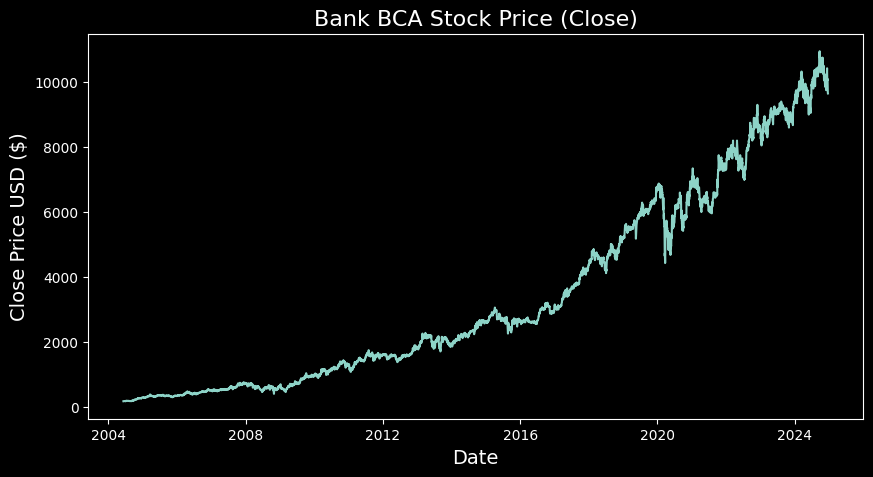

In [16]:
import matplotlib.pyplot as plt

# Plot dengan ukuran lebih kecil
plt.figure(figsize=(10, 5))  # Ukuran lebih kecil
plt.title('Bank BCA Stock Price (Close)', fontsize=16)
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.show()


Membagi dataset menjadi set pelatihan (80%) dan pengujian (20%)

In [17]:
import pandas as pd

# Assuming 'data' is your DataFrame
# Membagi data menjadi 80% train dan 20% test
train_size = int(len(data) * 0.80)  # Hitung ukuran training data
training_data = pd.DataFrame(data[0:train_size])  # Ambil 80% pertama untuk training
testing_data = pd.DataFrame(data[train_size:])   # Ambil 20% sisanya untuk testing

print("Training data shape:", training_data.shape)
print("Testing data shape:", testing_data.shape)


Training data shape: (4065, 1)
Testing data shape: (1017, 1)


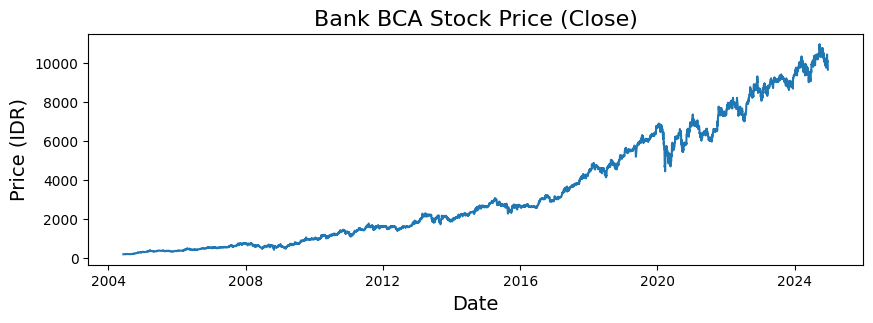

In [18]:
import matplotlib.pyplot as plt

plt.style.use('default')  # Menggunakan gaya warna default dari Matplotlib
# Plot dengan ukuran lebih kecil
plt.figure(figsize=(10, 3))  # Ukuran lebih kecil
plt.title('Bank BCA Stock Price (Close)', fontsize=16)
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (IDR)', fontsize=14)
plt.show()


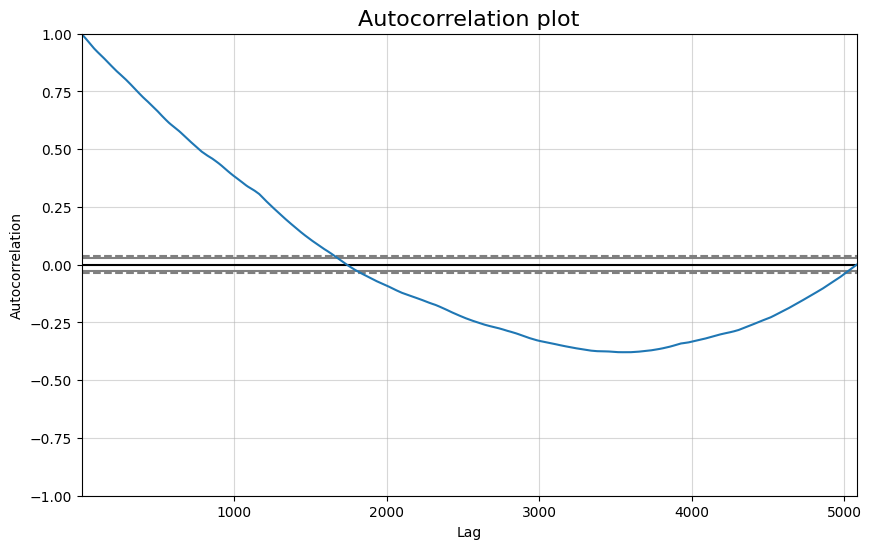

In [19]:
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

# Pastikan latar belakang putih
plt.style.use('default')  # Mengatur gaya default dengan latar belakang putih

# Plot autocorrelation
plt.figure(figsize=(10, 6))  # Menentukan ukuran grafik
autocorrelation_plot(df['Close'])  # Gunakan kolom 'Close' atau sesuai data Anda
plt.title('Autocorrelation plot', fontsize=16)
plt.grid(True, alpha=0.5)  # Menambahkan grid dengan transparansi
plt.show()


In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


In [21]:
# Misalnya, gunakan kolom 'Close' dari data historis saham
data_series = data['Close']

# Lakukan dekomposisi dengan model aditif
decomposition = seasonal_decompose(data_series, model='additive', period=30)  # 'period' menyesuaikan dengan frekuensi data


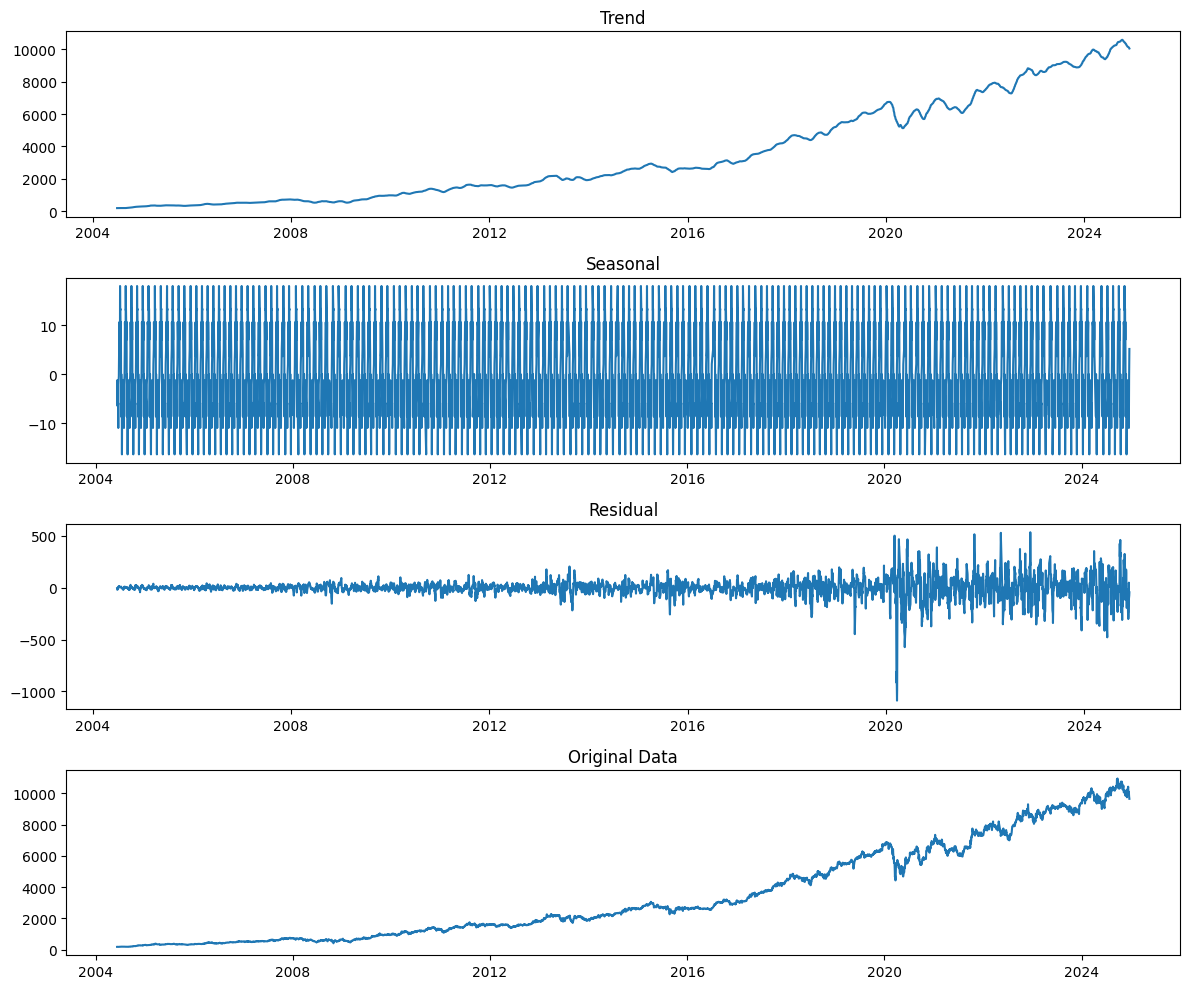

In [22]:
# Plot hasil dekomposisi
plt.figure(figsize=(12, 10))

plt.subplot(411)
plt.plot(decomposition.trend)
plt.title('Trend')

plt.subplot(412)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')

plt.subplot(413)
plt.plot(decomposition.resid)
plt.title('Residual')

plt.subplot(414)
plt.plot(data)
plt.title('Original Data')

plt.tight_layout()
plt.show()


In [23]:
training_data.head()

,Close
Date,
2004-06-08,177.5
2004-06-09,180.0
2004-06-10,180.0
2004-06-11,180.0
2004-06-14,177.5


In [24]:
#Melihat jumlah training data
training_data_len=len(training_data)
training_data_len

4065

In [25]:
testing_data.head()

,Close
Date,
2020-10-12,5855.0
2020-10-13,5855.0
2020-10-14,5900.0
2020-10-15,5785.0
2020-10-16,5760.0


In [26]:
#Melihat jumlah testing data
testing_data_len=len(testing_data)
testing_data_len

1017

In [27]:
#Convert data to np array
dataset=data.values

dataset

array([[ 177.5],
       [ 180. ],
       [ 180. ],
       ...,
       [9800. ],
       [9675. ],
       [9650. ]])

In [28]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00000000e+00],
       [2.32072407e-04],
       [2.32072407e-04],
       ...,
       [8.93246693e-01],
       [8.81643073e-01],
       [8.79322349e-01]])

In [29]:
#Create training dataset
#Create scaled training dataset
train_data = scaled_data[0:training_data_len,:]
train_data

array([[0.00000000e+00],
       [2.32072407e-04],
       [2.32072407e-04],
       ...,
       [5.17753539e-01],
       [5.20074263e-01],
       [5.19610118e-01]])

In [30]:
#Split the data into x_train and y_train data set
x_train=[]
y_train=[]

#setiap sampel dihasilkan dari jendela waktu (window) sepanjang 60 hari waktu sebelumnya
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.        , 0.00023207, 0.00023207, 0.00023207, 0.        ,
       0.00046414, 0.00023207, 0.        , 0.        , 0.        ,
       0.        , 0.00023207, 0.00023207, 0.00046414, 0.00046414,
       0.00069622, 0.00092829, 0.        , 0.00023207, 0.00023207,
       0.00092829, 0.00092829, 0.00092829, 0.00116036, 0.00116036,
       0.00139243, 0.00092829, 0.00092829, 0.00116036, 0.00116036,
       0.00116036, 0.00116036, 0.00116036, 0.00116036, 0.00092829,
       0.00092829, 0.00092829, 0.00092829, 0.00092829, 0.00069622,
       0.00092829, 0.00116036, 0.00116036, 0.00092829, 0.00046414,
       0.00046414, 0.00069622, 0.00046414, 0.00046414, 0.00023207,
       0.00023207, 0.00069622, 0.00069622, 0.00046414, 0.00046414,
       0.00046414, 0.00023207, 0.00023207, 0.00046414, 0.        ])]
[0.00023207240659085804]



In [31]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [32]:
#Reshape the data into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(4005, 60, 1)

# Membuat Model LSTM

In [33]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

# Example input shape; replace this with the actual shape of x_train
input_shape = (60, 1)  # Assuming 60 timesteps and 1 feature

# Create the LSTM model
model_LSTM = Sequential()
model_LSTM.add(LSTM(50, return_sequences=True, input_shape=input_shape))
model_LSTM.add(LSTM(50, return_sequences=False))
model_LSTM.add(Dense(25))
model_LSTM.add(Dense(1))

# Compile the model
model_LSTM.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Print the model summary
print(model_LSTM.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

None


## Model training

Input Layer

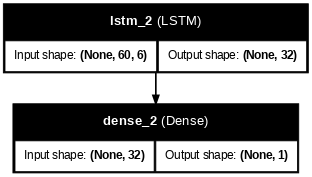

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model

# Misal time_steps = 60, dan fitur = 6
time_steps = 60
num_features = 6

# Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(time_steps, num_features), activation='relu', return_sequences=False))  # 6 fitur sebagai input
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')

# Visualize the model
plot_model(lstm, show_shapes=True, show_layer_names=True, dpi=60)  # Adjust the dpi to make the image smaller



Hidden Layer

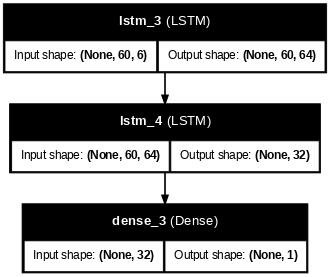

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model

# Define the number of timesteps and features
time_steps = 60  # Adjust this based on your data
num_features = 6

# Building the LSTM Model with Hidden Layers
lstm = Sequential()

# Input layer + First LSTM hidden layer
lstm.add(LSTM(64, input_shape=(time_steps, num_features), activation='relu', return_sequences=True))

# Second LSTM hidden layer
lstm.add(LSTM(32, activation='relu', return_sequences=False))  # No need to return sequences in the last LSTM layer

# Output layer
lstm.add(Dense(1))

# Compile the model
lstm.compile(loss='mean_squared_error', optimizer='adam')

# Visualize the model with a smaller size
plot_model(lstm, show_shapes=True, show_layer_names=True, dpi=60)  # Adjust the dpi to make the image smaller


Attention Layer

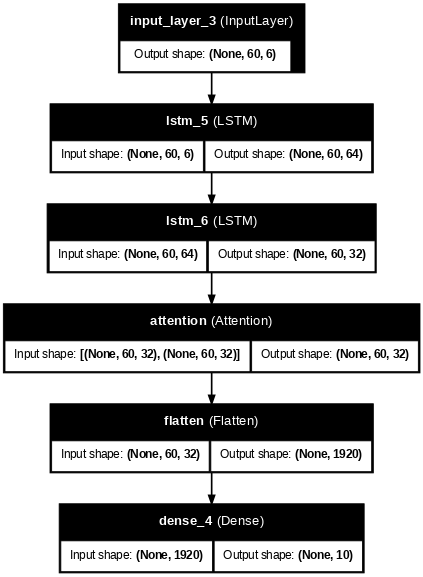

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Attention, Input, Concatenate, Flatten
from tensorflow.keras.utils import plot_model

# Define the number of timesteps and features
time_steps = 60  # Adjust this based on your data
num_features = 6  # This corresponds to the features: open, high, low, close, adj close, volume
num_classes = 10  # Adjust this to the number of output classes

# Building the LSTM Model with Attention Layer
inputs = Input(shape=(time_steps, num_features))

# First LSTM hidden layer
lstm_out_1 = LSTM(64, return_sequences=True)(inputs)

# Second LSTM hidden layer
lstm_out_2 = LSTM(32, return_sequences=True)(lstm_out_1)

# Attention layer
attention = Attention()([lstm_out_2, lstm_out_2])  # Correct self-attention implementation

# Flatten the output from attention layer
attention_flattened = Flatten()(attention)

# Output layer with softmax activation
output = Dense(num_classes, activation='softmax')(attention_flattened)

# Create the model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Visualize the model
plot_model(model, show_shapes=True, show_layer_names=True, dpi=60)  # Adjust 'dpi' for smaller output



Melakukan Epoch sebanyak 3 kali



In [37]:
#Compile the model
model_LSTM.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model_LSTM.fit(x_train, y_train, batch_size=1,epochs=3 )

Epoch 1/3
4005/4005 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 0.0010
Epoch 2/3
4005/4005 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 1.9588e-04
Epoch 3/3
4005/4005 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 1.2788e-04


In [38]:
# Membuat dataset pengujian (test_data)
test_data = scaled_data[training_data_len-60:, :]
test_data

array([[0.55906243],
       [0.55442098],
       [0.55720585],
       ...,
       [0.89324669],
       [0.88164307],
       [0.87932235]])

In [39]:
x_test=[]
y_test=[]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    y_test.append(test_data[i, 0])

In [40]:
#Convert the data to a numpy array
x_test,y_test = np.array(x_test), np.array(y_test)

In [41]:
#Reshape the data to 3d
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [42]:
prediction_LSTM = model_LSTM.predict(x_test)
print('r2_score_LSTM: ',r2_score(y_test, prediction_LSTM))
print('MAE_LSTM: ', mean_absolute_error(y_test, prediction_LSTM))
print('MSE_LSTM: ', mean_squared_error(y_test, prediction_LSTM))
print('rmse_LSTM: ',mean_squared_error(y_test, prediction_LSTM))
prediction_LSTM = scaler.inverse_transform(prediction_LSTM)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
r2_score_LSTM:  0.9232453598467667
MAE_LSTM:  0.029621512061680545
MSE_LSTM:  0.0011497064214524297
rmse_LSTM:  0.0011497064214524297


In [43]:
prediction_LSTM[-1]

array([9226.856], dtype=float32)

In [44]:
data_len=len(dataset)

<ipython-input-45-b875f07407cf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Prediction_LSTM'] = prediction_LSTM


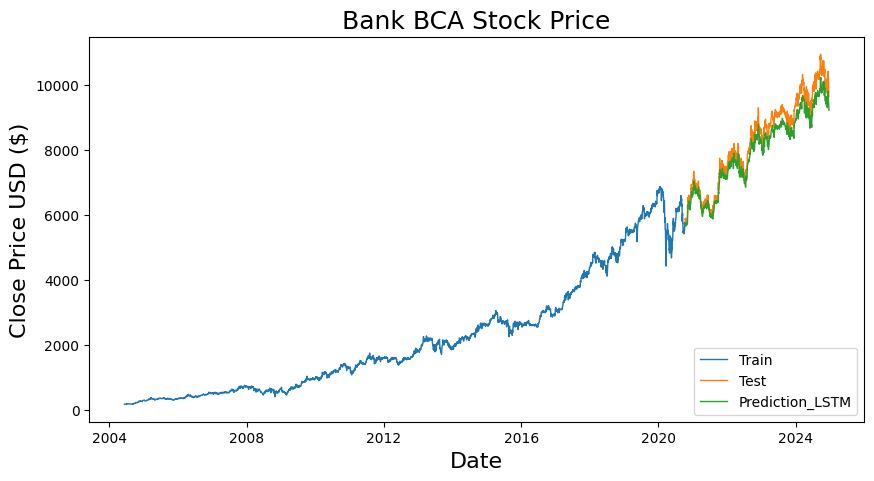

In [45]:
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Prediction_LSTM'] = prediction_LSTM

#visualisasi
plt.figure(figsize=(10,5))
plt.title('Bank BCA Stock Price', fontsize = 18)
plt.xlabel('Date', fontsize = 16 )
plt.ylabel('Close Price USD ($)', fontsize = 16 )
plt.plot(train['Close'],linewidth=1)
plt.plot(valid[['Close','Prediction_LSTM']],linewidth=1)
plt.legend(['Train','Test','Prediction_LSTM'], loc = 'lower right')
plt.show()

In [46]:
#Show the valid and predicted prices
valid.tail(5)

,Close,Prediction_LSTM
Date,,
2024-12-16,10100.0,9498.260742
2024-12-17,9900.0,9507.185547
2024-12-18,9800.0,9405.063477
2024-12-19,9675.0,9317.804688
2024-12-20,9650.0,9226.856445


Melakukan Epoch sebanyak 60 kali

In [47]:
#Compile the model
model_LSTM.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model_LSTM.fit(x_train, y_train, batch_size=32,epochs=60 )

Epoch 1/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.7944e-05
Epoch 2/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.2620e-05
Epoch 3/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2761e-05
Epoch 4/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.3842e-05
Epoch 5/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.3432e-05
Epoch 6/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3534e-05
Epoch 7/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.2937e-05
Epoch 8/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0972e-05
Epoch 9/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5196e-05
Epoch 10/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.3062e-05
Epoch 11/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.3464e-05
Epoch 12/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.2413e-05
Epoch 13/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.6146e-05
Epoch 14/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5524e-05

In [48]:
# Membuat dataset pengujian (test_data)
test_data = scaled_data[training_data_len-60:, :]
test_data

array([[0.55906243],
       [0.55442098],
       [0.55720585],
       ...,
       [0.89324669],
       [0.88164307],
       [0.87932235]])

In [49]:
x_test=[]
y_test=[]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    y_test.append(test_data[i, 0])

In [50]:
#Convert the data to a numpy array
x_test,y_test = np.array(x_test), np.array(y_test)

In [51]:
#Reshape the data to 3d
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [52]:
prediction_LSTM = model_LSTM.predict(x_test)
print('r2_score_LSTM: ',r2_score(y_test, prediction_LSTM))
print('MAE_LSTM: ', mean_absolute_error(y_test, prediction_LSTM))
print('MSE_LSTM: ', mean_squared_error(y_test, prediction_LSTM))
print('rmse_LSTM: ',mean_squared_error(y_test, prediction_LSTM))
prediction_LSTM = scaler.inverse_transform(prediction_LSTM)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
r2_score_LSTM:  0.9907044058688351
MAE_LSTM:  0.009359990470744352
MSE_LSTM:  0.00013923854300508526
rmse_LSTM:  0.00013923854300508526


In [53]:
prediction_LSTM[-1]

array([9652.228], dtype=float32)

In [54]:
data_len=len(dataset)

<ipython-input-55-639a8dc22c03>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Prediction_LSTM'] = prediction_LSTM


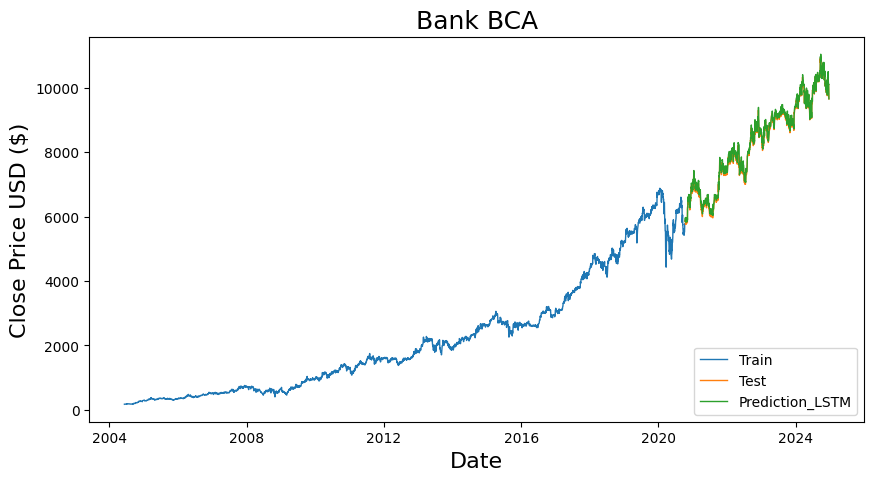

In [55]:
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Prediction_LSTM'] = prediction_LSTM

#visualisasi
plt.figure(figsize=(10,5))
plt.title('Bank BCA', fontsize = 18)
plt.xlabel('Date', fontsize = 16 )
plt.ylabel('Close Price USD ($)', fontsize = 16 )
plt.plot(train['Close'],linewidth=1)
plt.plot(valid[['Close','Prediction_LSTM']],linewidth=1)
plt.legend(['Train','Test','Prediction_LSTM'], loc = 'lower right')
plt.show()

In [56]:
# Menampilkan 5 baris terakhir dari valid
print("Data Valid - 5 Baris Terakhir:")
print(valid.tail(5))

# Menampilkan 5 baris pertama dari valid
print("\nData Valid - 5 Baris Pertama:")
print(valid.head(5))


Data Valid - 5 Baris Terakhir:
              Close  Prediction_LSTM
Date                                
2024-12-16  10100.0     10091.451172
2024-12-17   9900.0     10110.939453
2024-12-18   9800.0      9890.708984
2024-12-19   9675.0      9799.479492
2024-12-20   9650.0      9652.227539

Data Valid - 5 Baris Pertama:
             Close  Prediction_LSTM
Date                               
2020-10-12  5855.0      5850.152344
2020-10-13  5855.0      5927.654785
2020-10-14  5900.0      5921.260742
2020-10-15  5785.0      5970.972168
2020-10-16  5760.0      5850.076660


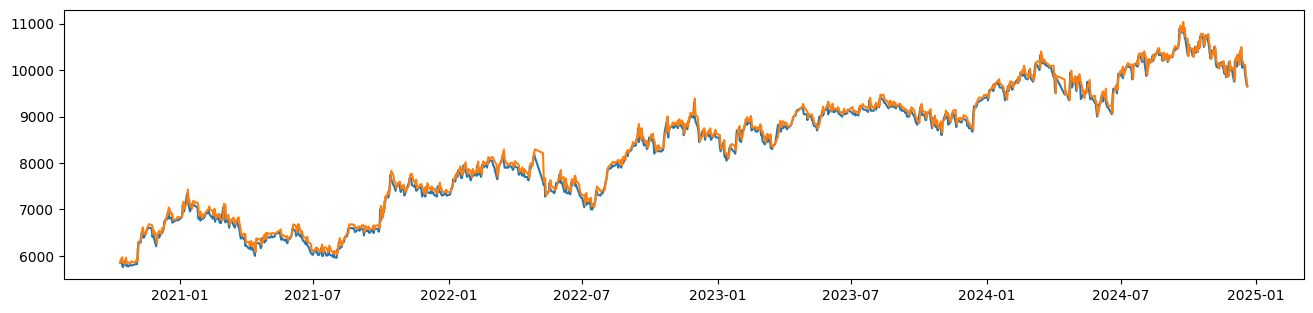

In [57]:
plt.figure(figsize=(16,3.5))
plt.plot(valid[['Close','Prediction_LSTM']],linewidth=1.5)

In [58]:
# Simpan hasil prediksi pada datatest dalam file xlsx
valid.to_excel('/content/drive/MyDrive/Project Tesis/PrediksiDataTest/BBCA_PREDIC_DATATEST_LSTM.xlsx')

### Prediksi 30 Hari kedepan

In [59]:
def smooth_prediction(previous_value, predicted_value, alpha=0.9):
    """
    Applies exponential smoothing to the predicted value.
    :param previous_value: The previous actual value.
    :param predicted_value: The predicted value from the model.
    :param alpha: The smoothing factor (between 0 and 1).
    :return: The smoothed value.
    """
    return alpha * predicted_value + (1 - alpha) * previous_value


In [60]:
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values)

# Ambil panjang data
data_len = len(scaled_data)

# Ambil 30 data terakhir
data_input = scaled_data[data_len-30:data_len, :]

# Tanggal awal untuk prediksi
start_date = datetime.now()  # Anda bisa mengganti ini dengan tanggal tertentu

# Inisialisasi list untuk menyimpan hasil prediksi
hasil_prediksi_LSTM_list = []

# Fungsi untuk smoothing prediksi
def smooth_prediction(previous_value, predicted_value, alpha=0.9):
    return alpha * previous_value + (1 - alpha) * predicted_value

# Melakukan prediksi untuk 30 hari ke depan
for day in range(30):
    # Reshape input untuk model LSTM
    x_input = data_input.reshape(1, data_input.shape[0], 1)

    # Prediksi menggunakan model LSTM
    predicted_value = model_LSTM.predict(x_input)

    # Smooth hasil prediksi
    smoothed_value = smooth_prediction(data_input[-1, 0], predicted_value[0, 0], alpha=0.9)

    # Simpan hasil prediksi
    hasil_prediksi_LSTM_list.append(smoothed_value)

    # Update data_input dengan prediksi yang baru
    data_input = np.append(data_input, smoothed_value).reshape(-1, 1)

    # Ambil 30 elemen terakhir
    data_input = data_input[-30:]

# Lakukan inverse scaling pada hasil prediksi
hasil_prediksi_LSTM_list = scaler.inverse_transform(np.array(hasil_prediksi_LSTM_list).reshape(-1, 1))

# Buat DataFrame dari list hasil_prediksi_LSTM_list dan indeksnya berupa tanggal
df_hasil_prediksi_LSTM = pd.DataFrame(
    hasil_prediksi_LSTM_list,
    index=pd.date_range(start=start_date, periods=30, freq='D'),
    columns=['Prediction_LSTM']
)

# Menamai kolom indeks sebagai "Date"
df_hasil_prediksi_LSTM.index.name = 'Date'

# Simpan DataFrame ke dalam file xlsx
df_hasil_prediksi_LSTM.to_excel('/content/drive/MyDrive/Project Tesis/Prediksi30hari/BBCA_PREDIC_30DAYS_LSTM.xlsx')

# Cetak DataFrame hasil prediksi
print(df_hasil_prediksi_LSTM)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

# Membuat model RNN

In [61]:
from tensorflow.keras.layers import SimpleRNN, Dense

epoch=3

model_RNN = Sequential()
model_RNN.add(SimpleRNN(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model_RNN.add(SimpleRNN(50, return_sequences=False))
model_RNN.add(Dense(25))
model_RNN.add(Dense(1))

print(model_RNN.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 60, 50)              │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,951 (34.96 KB)

 Trainable params: 8,951 (34.96 KB)

 Non-trainable params: 0 (0.00 B)

None


Input Layer

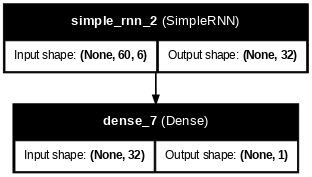

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.utils import plot_model

# Misal time_steps = 60, dan fitur = 6
time_steps = 60
num_features = 6

# Building the RNN Model
rnn = Sequential()
rnn.add(Input(shape=(time_steps, num_features)))  # Layer input eksplisit
rnn.add(SimpleRNN(32, activation='relu', return_sequences=False))  # Menggunakan SimpleRNN
rnn.add(Dense(1))  # Output layer
rnn.compile(loss='mean_squared_error', optimizer='adam')

# Visualize the model with a smaller display
plot_model(rnn, show_shapes=True, show_layer_names=True, dpi=60)  # Set dpi lebih rendah untuk ukuran gambar lebih kecil


Hidden Layer

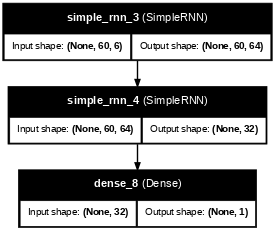

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.utils import plot_model

# Define the number of timesteps and features
time_steps = 60  # Adjust this based on your data
num_features = 6

# Building the RNN Model with Hidden Layers
rnn = Sequential()

# Input layer + First RNN hidden layer
rnn.add(Input(shape=(time_steps, num_features)))  # Input layer
rnn.add(SimpleRNN(64, activation='relu', return_sequences=True))  # First RNN layer

# Second RNN hidden layer
rnn.add(SimpleRNN(32, activation='relu', return_sequences=False))  # No need to return sequences in the last RNN layer

# Output layer
rnn.add(Dense(1))

# Compile the model
rnn.compile(loss='mean_squared_error', optimizer='adam')

# Visualize the model with a smaller display
plot_model(rnn, show_shapes=True, show_layer_names=True, dpi=50)  # Set dpi lebih rendah untuk ukuran gambar lebih kecil


Attention Layer

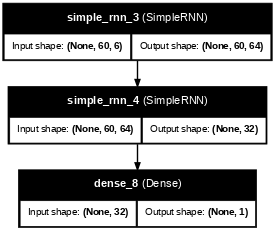

In [64]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Model Seq2Seq dengan Attention
def build_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # LSTM layer
    lstm = layers.LSTM(64, return_sequences=True)(inputs)

    # Attention mechanism
    attention = layers.Attention()([lstm, lstm])  # self-attention

    # RNN layer untuk menghasilkan output
    lstm2 = layers.LSTM(32)(attention)

    # Fully connected layer untuk output
    output = layers.Dense(1)(lstm2)

    model = models.Model(inputs=inputs, outputs=output)

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

# Membangun model
model = build_model((x_train.shape[1], 1))

# Visualize the model with a smaller display
plot_model(rnn, show_shapes=True, show_layer_names=True, dpi=50)  # Set dpi lebih rendah untuk ukuran gambar lebih kecil



Melakukan Epoch sebanyak 3 kali

In [65]:
#Compile the model
model_RNN.compile(optimizer='adam', loss='mean_squared_error')

In [66]:
#Train the model
model_RNN.fit(x_train, y_train, batch_size=1,epochs=3 )

Epoch 1/3
4005/4005 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 0.0023
Epoch 2/3
4005/4005 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 1.0729e-04
Epoch 3/3
4005/4005 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 1.9812e-04


In [67]:
prediction_RNN = model_RNN.predict(x_test)
print('r2_score_RNN: ',r2_score(y_test, prediction_RNN))
print('MAE_RNN: ', mean_absolute_error(y_test, prediction_RNN))
print('MSE_RNN: ', mean_squared_error(y_test, prediction_RNN))
print('rmse_RNN: ',mean_squared_error(y_test, prediction_RNN))
prediction_RNN = scaler.inverse_transform(prediction_RNN)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
r2_score_RNN:  0.9407342156698402
MAE_RNN:  0.02581543919198608
MSE_RNN:  0.0008877411538998547
rmse_RNN:  0.0008877411538998547


In [68]:
prediction_RNN[-1]

array([9208.268], dtype=float32)

<ipython-input-69-f94ee92ec8d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_RNN['Prediction_RNN'] = prediction_RNN


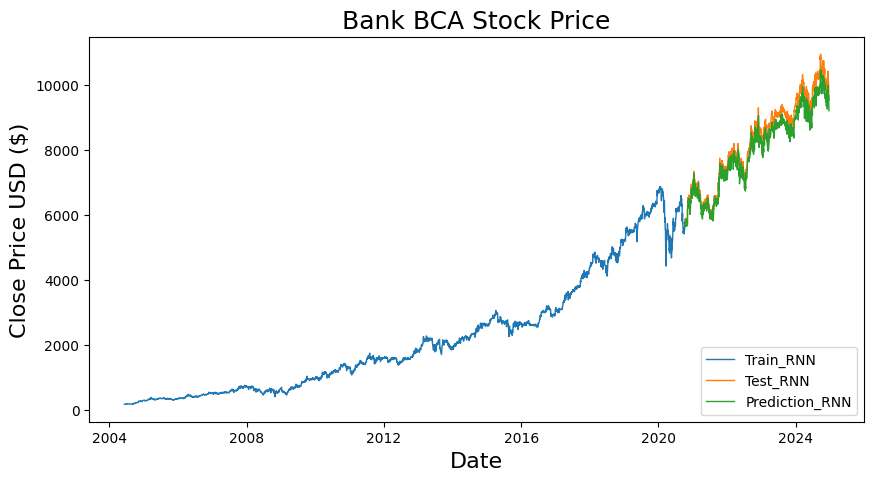

In [69]:
train_RNN=data[:training_data_len]
valid_RNN=data[training_data_len:]
valid_RNN['Prediction_RNN'] = prediction_RNN

#visualisasi
plt.figure(figsize=(10,5))
plt.title('Bank BCA Stock Price', fontsize = 18)
plt.xlabel('Date', fontsize = 16 )
plt.ylabel('Close Price USD ($)', fontsize = 16 )
plt.plot(train_RNN['Close'],linewidth=1)
plt.plot(valid_RNN[['Close','Prediction_RNN']],linewidth=1)
plt.legend(['Train_RNN','Test_RNN','Prediction_RNN'], loc = 'lower right')
plt.show()

In [70]:
#Show the valid and predicted prices
valid_RNN.tail(5)


,Close,Prediction_RNN
Date,,
2024-12-16,10100.0,9524.361328
2024-12-17,9900.0,9686.280273
2024-12-18,9800.0,9362.504883
2024-12-19,9675.0,9361.396484
2024-12-20,9650.0,9208.267578


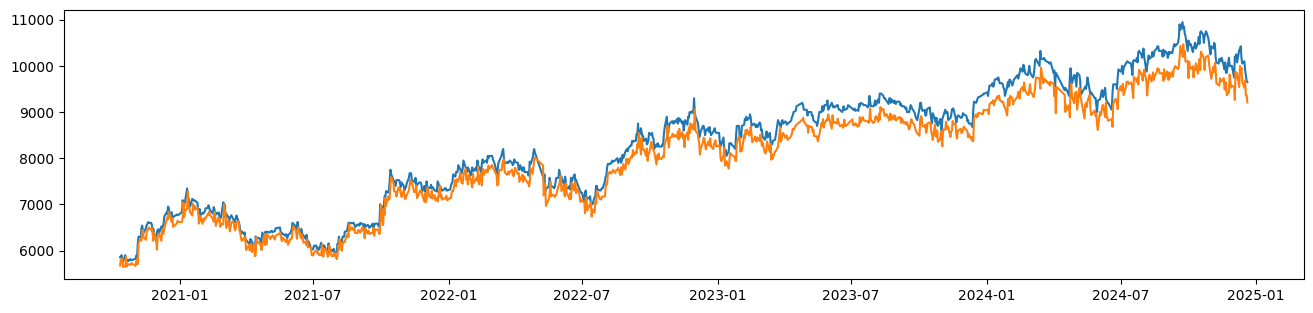

In [71]:
plt.figure(figsize=(16,3.5))
plt.plot(valid_RNN[['Close','Prediction_RNN']],linewidth=1.5)

Melakukan Epoch Sebanyak 60 kali

In [72]:
#Compile the model
model_RNN.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model_RNN.fit(x_train, y_train, batch_size=32,epochs=60 )

Epoch 1/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 7.6640e-05
Epoch 2/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1050e-05
Epoch 3/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.3150e-05
Epoch 4/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.4173e-05
Epoch 5/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4589e-05
Epoch 6/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.5740e-05
Epoch 7/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.1444e-05
Epoch 8/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5286e-05
Epoch 9/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.1444e-05
Epoch 10/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.7744e-05
Epoch 11/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.2440e-05
Epoch 12/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.4471e-05
Epoch 13/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 3.3325e-05
Epoch 14/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss

In [73]:
# Membuat dataset pengujian (test_data)
test_data = scaled_data[training_data_len-60:, :]
test_data

array([[0.55906243],
       [0.55442098],
       [0.55720585],
       ...,
       [0.89324669],
       [0.88164307],
       [0.87932235]])

In [74]:
x_test=[]
y_test=[]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    y_test.append(test_data[i, 0])

In [75]:
#Convert the data to a numpy array
x_test,y_test = np.array(x_test), np.array(y_test)

In [76]:
#Reshape the data to 3d
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [77]:
prediction_RNN = model_RNN.predict(x_test)
print('r2_score_RNN: ',r2_score(y_test, prediction_RNN))
print('MAE_RNN: ', mean_absolute_error(y_test, prediction_RNN))
print('MSE_RNN: ', mean_squared_error(y_test, prediction_RNN))
print('rmse_RNN: ',mean_squared_error(y_test, prediction_RNN))
prediction_RNN = scaler.inverse_transform(prediction_RNN)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
r2_score_RNN:  0.9878990459008865
MAE_RNN:  0.010315799537592745
MSE_RNN:  0.0001812599812294978
rmse_RNN:  0.0001812599812294978


In [78]:
prediction_RNN[-1]

array([9524.299], dtype=float32)

In [79]:
data_len=len(dataset)

<ipython-input-80-f94ee92ec8d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_RNN['Prediction_RNN'] = prediction_RNN


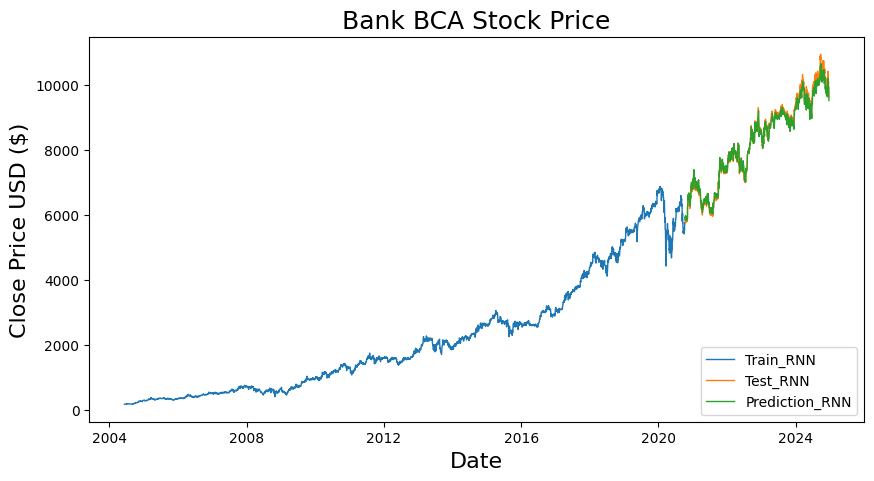

In [80]:
train_RNN=data[:training_data_len]
valid_RNN=data[training_data_len:]
valid_RNN['Prediction_RNN'] = prediction_RNN

#visualisasi
plt.figure(figsize=(10,5))
plt.title('Bank BCA Stock Price', fontsize = 18)
plt.xlabel('Date', fontsize = 16 )
plt.ylabel('Close Price USD ($)', fontsize = 16 )
plt.plot(train_RNN['Close'],linewidth=1)
plt.plot(valid_RNN[['Close','Prediction_RNN']],linewidth=1)
plt.legend(['Train_RNN','Test_RNN','Prediction_RNN'], loc = 'lower right')
plt.show()

In [81]:
# Menampilkan 5 baris terakhir dari valid
print("Data Valid - 5 Baris Terakhir:")
print(valid.tail(5))

# Menampilkan 5 baris pertama dari valid
print("\nData Valid - 5 Baris Pertama:")
print(valid.head(5))


Data Valid - 5 Baris Terakhir:
              Close  Prediction_LSTM
Date                                
2024-12-16  10100.0     10091.451172
2024-12-17   9900.0     10110.939453
2024-12-18   9800.0      9890.708984
2024-12-19   9675.0      9799.479492
2024-12-20   9650.0      9652.227539

Data Valid - 5 Baris Pertama:
             Close  Prediction_LSTM
Date                               
2020-10-12  5855.0      5850.152344
2020-10-13  5855.0      5927.654785
2020-10-14  5900.0      5921.260742
2020-10-15  5785.0      5970.972168
2020-10-16  5760.0      5850.076660


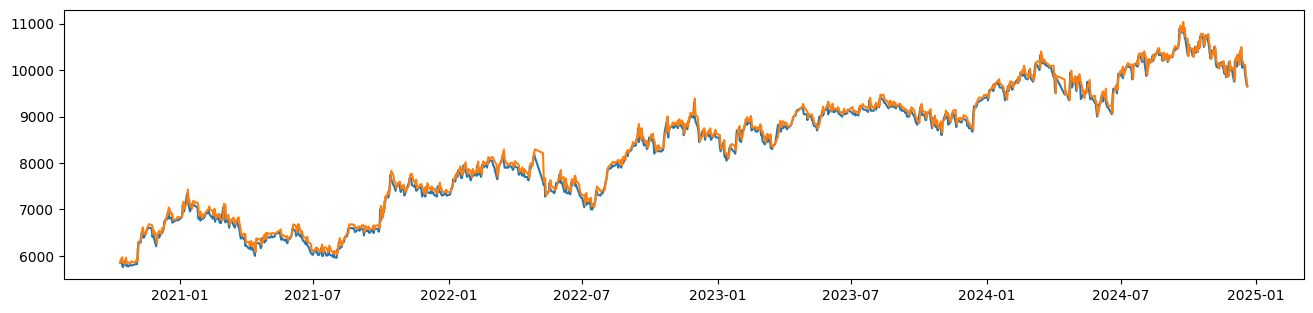

In [82]:
plt.figure(figsize=(16,3.5))
plt.plot(valid[['Close','Prediction_LSTM']],linewidth=1.5)

In [83]:
# Simpan hasil prediksi pada datatest dalam file xlsx
valid.to_excel('/content/drive/MyDrive/Project Tesis/PrediksiDataTest/BBCA_PREDIC_DATATEST_RNN.xlsx')

Prediksi 30 Hari kedepan

In [84]:
def smooth_prediction(previous_value, predicted_value, alpha=0.9):
    """
    Applies exponential smoothing to the predicted value.
    :param previous_value: The previous actual value.
    :param predicted_value: The predicted value from the model.
    :param alpha: The smoothing factor (between 0 and 1).
    :return: The smoothed value.
    """
    return alpha * predicted_value + (1 - alpha) * previous_value


In [85]:
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# Misalkan 'data' adalah DataFrame yang berisi data harga yang akan diprediksi
# Contoh: data = pd.DataFrame({'Price': [....]})

# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values)

# Ambil panjang data
data_len = len(scaled_data)

# Ambil 30 data terakhir
data_input = scaled_data[data_len-30:data_len, :]

# Tanggal awal untuk prediksi
start_date = datetime.now()  # Anda bisa mengganti ini dengan tanggal tertentu

# Inisialisasi list untuk menyimpan hasil prediksi
hasil_prediksi_RNN_list = []

# Fungsi untuk smoothing prediksi
def smooth_prediction(previous_value, predicted_value, alpha=0.9):
    return alpha * previous_value + (1 - alpha) * predicted_value

# Melakukan prediksi untuk 30 hari ke depan
for day in range(30):
    # Reshape input untuk model RNN
    x_input = data_input.reshape(1, data_input.shape[0], 1)

    # Prediksi menggunakan model RNN
    predicted_value = model_RNN.predict(x_input)

    # Smooth hasil prediksi
    smoothed_value = smooth_prediction(data_input[-1, 0], predicted_value[0, 0], alpha=0.9)

    # Simpan hasil prediksi
    hasil_prediksi_RNN_list.append(smoothed_value)

    # Update data_input dengan prediksi yang baru
    data_input = np.append(data_input, smoothed_value).reshape(-1, 1)

    # Ambil 30 elemen terakhir
    data_input = data_input[-30:]

# Lakukan inverse scaling pada hasil prediksi
hasil_prediksi_RNN_list = scaler.inverse_transform(np.array(hasil_prediksi_RNN_list).reshape(-1, 1))

# Buat DataFrame dari list hasil_prediksi_RNN_list dan indeksnya berupa tanggal
df_hasil_prediksi_RNN = pd.DataFrame(
    hasil_prediksi_RNN_list,
    index=pd.date_range(start=start_date, periods=30, freq='D'),
    columns=['Prediction_RNN']
)

# Menamai kolom indeks sebagai "Date"
df_hasil_prediksi_RNN.index.name = 'Date'

# Simpan DataFrame ke dalam file xlsx
df_hasil_prediksi_RNN.to_excel('/content/drive/MyDrive/Project Tesis/Prediksi30hari/BBCA_PREDIC_30DAYS_RNN.xlsx')

# Cetak DataFrame hasil prediksi
print(df_hasil_prediksi_RNN)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

# Membuat Model GRU

In [86]:
from tensorflow.keras.layers import GRU

epoch=3

model_GRU = Sequential()
model_GRU.add(GRU(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model_GRU.add(GRU(50, return_sequences=False))
model_GRU.add(Dense(25))
model_GRU.add(Dense(1))

print(model_GRU.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 60, 50)              │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,551 (95.90 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

None


Input Layer

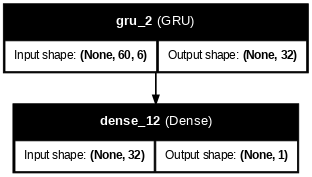

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input
from tensorflow.keras.utils import plot_model

# Misal time_steps = 60, dan fitur = 6
time_steps = 60
num_features = 6

# Building the GRU Model
gru = Sequential()
gru.add(Input(shape=(time_steps, num_features)))  # Layer input eksplisit
gru.add(GRU(32, activation='relu', return_sequences=False))  # Menggunakan GRU
gru.add(Dense(1))  # Output layer
gru.compile(loss='mean_squared_error', optimizer='adam')

# Visualize the model with a smaller display
plot_model(gru, show_shapes=True, show_layer_names=True, dpi=60)  # Set dpi untuk ukuran gambar lebih kecil


Hidden Layer

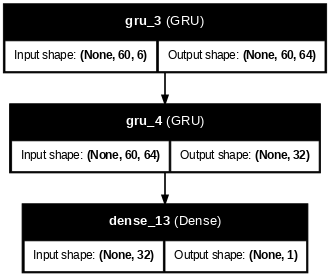

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input
from tensorflow.keras.utils import plot_model

# Define the number of timesteps and features
time_steps = 60  # Adjust this based on your data
num_features = 6

# Building the GRU Model with Hidden Layers
gru = Sequential()

# Input layer + First GRU hidden layer
gru.add(Input(shape=(time_steps, num_features)))  # Input layer
gru.add(GRU(64, activation='relu', return_sequences=True))  # First GRU layer

# Second GRU hidden layer
gru.add(GRU(32, activation='relu', return_sequences=False))  # No need to return sequences in the last GRU layer

# Output layer
gru.add(Dense(1))

# Compile the model
gru.compile(loss='mean_squared_error', optimizer='adam')

# Visualize the model with a smaller display
plot_model(gru, show_shapes=True, show_layer_names=True, dpi=60)  # Set dpi for smaller output


Attention Layer

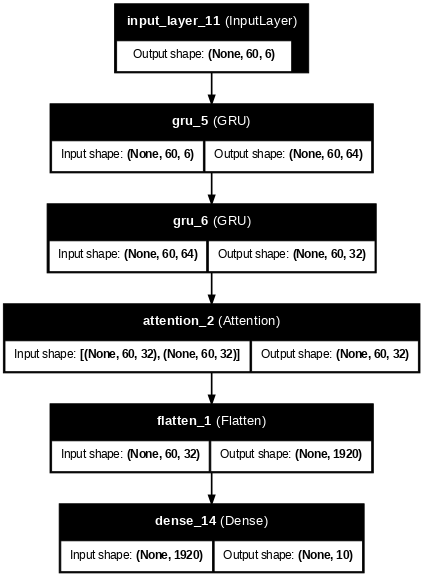

In [89]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, Dense, Attention, Input, Flatten
from tensorflow.keras.utils import plot_model

# Define the number of timesteps and features
time_steps = 60  # Adjust this based on your data
num_features = 6  # This corresponds to the features: open, high, low, close, adj close, volume
num_classes = 10  # Adjust this to the number of output classes

# Building the GRU Model with Attention Layer
inputs = Input(shape=(time_steps, num_features))

# First GRU hidden layer
gru_out_1 = GRU(64, return_sequences=True)(inputs)

# Second GRU hidden layer
gru_out_2 = GRU(32, return_sequences=True)(gru_out_1)

# Attention layer
attention = Attention()([gru_out_2, gru_out_2])  # Correct self-attention implementation

# Flatten the output from attention layer
attention_flattened = Flatten()(attention)

# Output layer with softmax activation
output = Dense(num_classes, activation='softmax')(attention_flattened)

# Create the model
gru_model = Model(inputs=inputs, outputs=output)

# Compile the model
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Visualize the model
plot_model(gru_model, show_shapes=True, show_layer_names=True, dpi=60)  # Adjust 'dpi' for smaller output


Model training

In [90]:
#Compile the model
model_GRU.compile(optimizer='adam', loss='mean_squared_error')

Melakukan Epoch sebanyak 3 kali

In [91]:
#Train the model
model_GRU.fit(x_train, y_train, batch_size=1,epochs=3 )

Epoch 1/3
4005/4005 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.0014
Epoch 2/3
4005/4005 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 1.2864e-04
Epoch 3/3
4005/4005 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 8.7842e-05


In [93]:
prediction_GRU = model_GRU.predict(x_test)
print('r2_score_GRU: ',r2_score(y_test, prediction_GRU))
print('MAE_GRU: ', mean_absolute_error(y_test, prediction_GRU))
print('MSE_GRU: ', mean_squared_error(y_test, prediction_GRU))
print('rmse_GRU: ',mean_squared_error(y_test, prediction_GRU))
prediction_GRU = scaler.inverse_transform(prediction_GRU)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
r2_score_GRU:  0.9544804903814667
MAE_GRU:  0.021581983360117258
MSE_GRU:  0.0006818359437984912
rmse_GRU:  0.0006818359437984912


In [94]:
prediction_GRU[-1]

array([9310.746], dtype=float32)

<ipython-input-95-b6a124679860>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_GRU['Prediction_GRU'] = prediction_GRU


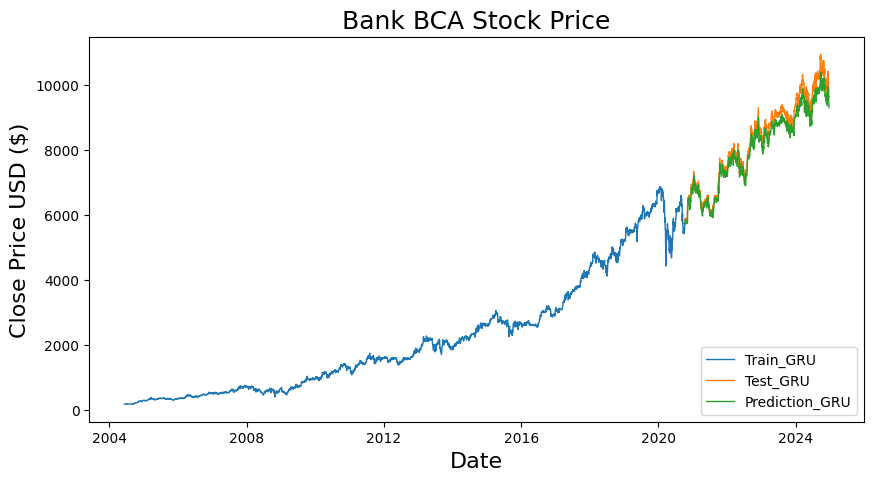

In [95]:
train_GRU=data[:training_data_len]
valid_GRU=data[training_data_len:]
valid_GRU['Prediction_GRU'] = prediction_GRU

#visualisasi
plt.figure(figsize=(10,5))
plt.title('Bank BCA Stock Price', fontsize = 18)
plt.xlabel('Date', fontsize = 16 )
plt.ylabel('Close Price USD ($)', fontsize = 16 )
plt.plot(train_GRU['Close'],linewidth=1)
plt.plot(valid_GRU[['Close','Prediction_GRU']],linewidth=1)
plt.legend(['Train_GRU','Test_GRU','Prediction_GRU'], loc = 'lower right')
plt.show()

In [96]:
#Show the valid and predicted prices
valid_GRU.tail(5)

,Close,Prediction_GRU
Date,,
2024-12-16,10100.0,9642.027344
2024-12-17,9900.0,9676.493164
2024-12-18,9800.0,9491.236328
2024-12-19,9675.0,9428.144531
2024-12-20,9650.0,9310.746094


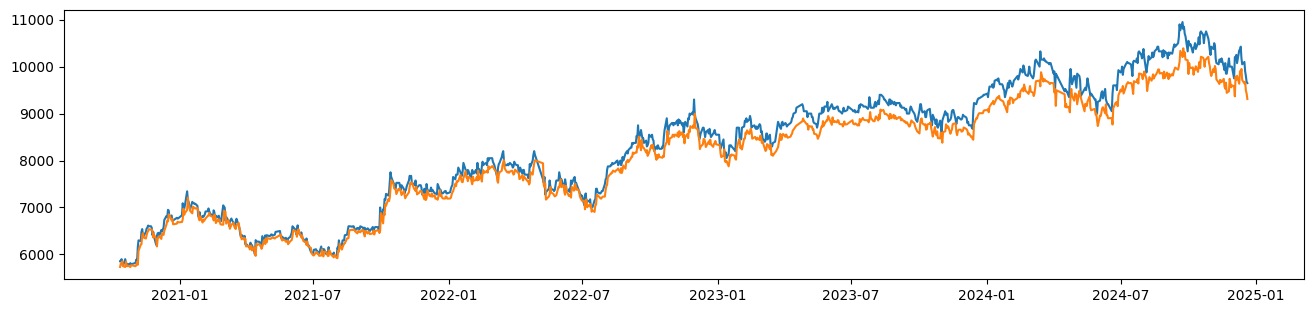

In [97]:
plt.figure(figsize=(16,3.5))
plt.plot(valid_GRU[['Close','Prediction_GRU']],linewidth=1.5)

In [98]:
# Simpan hasil prediksi pada datatest dalam file xlsx
valid.to_excel('/content/drive/MyDrive/Project Tesis/PrediksiDataTest/BBCA_PREDIC_DATATEST_GRU.xlsx')

Melakukan Epoch 60

In [99]:
#Compile the model
model_GRU.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model_GRU.fit(x_train, y_train, batch_size=32,epochs=60 )

Epoch 1/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.8107e-05
Epoch 2/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0464e-05
Epoch 3/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.5503e-05
Epoch 4/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1350e-05
Epoch 5/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2048e-05
Epoch 6/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.1951e-05
Epoch 7/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7344e-05
Epoch 8/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.2568e-05
Epoch 9/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.2043e-05
Epoch 10/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.4321e-05
Epoch 11/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0144e-05
Epoch 12/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8609e-05
Epoch 13/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3394e-05
Epoch 14/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0930e-05


In [100]:
# Membuat dataset pengujian (test_data)
test_data = scaled_data[training_data_len-60:, :]
test_data

array([[0.55906243],
       [0.55442098],
       [0.55720585],
       ...,
       [0.89324669],
       [0.88164307],
       [0.87932235]])

In [101]:
x_test=[]
y_test=[]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    y_test.append(test_data[i, 0])

In [102]:

#Convert the data to a numpy array
x_test,y_test = np.array(x_test), np.array(y_test)


In [103]:
#Reshape the data to 3d
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [104]:
prediction_GRU = model_GRU.predict(x_test)
print('r2_score_GRU: ',r2_score(y_test, prediction_GRU))
print('MAE_GRU: ', mean_absolute_error(y_test, prediction_GRU))
print('MSE_GRU: ', mean_squared_error(y_test, prediction_GRU))
print('rmse_GRU: ',mean_squared_error(y_test, prediction_GRU))
prediction_GRU = scaler.inverse_transform(prediction_GRU)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
r2_score_GRU:  0.9743340058326319
MAE_GRU:  0.015429988765415044
MSE_GRU:  0.0003844504807562526
rmse_GRU:  0.0003844504807562526


In [105]:
prediction_GRU[-1]

array([9404.906], dtype=float32)

In [106]:
data_len=len(dataset)

In [107]:
train=data[:training_data_len]
valid=data[training_data_len:]
valid['prediction_GRU'] = prediction_GRU

<ipython-input-107-4e4a4afe3fee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['prediction_GRU'] = prediction_GRU


<ipython-input-108-b6a124679860>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_GRU['Prediction_GRU'] = prediction_GRU


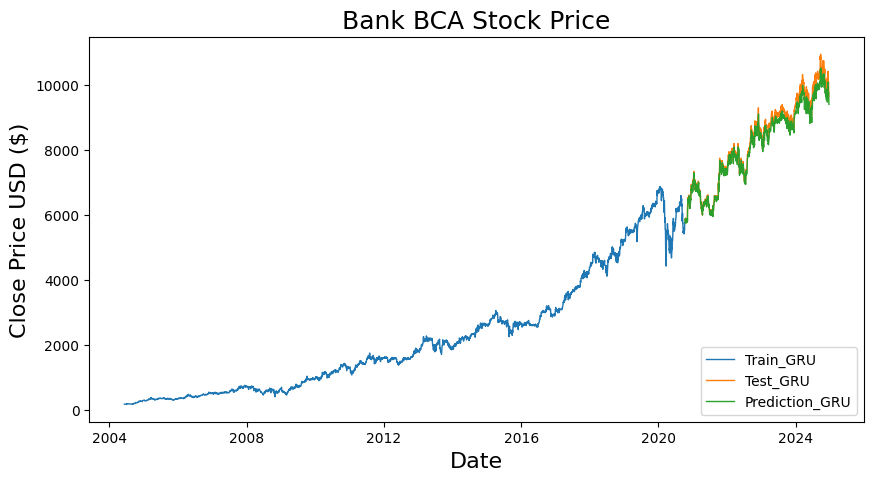

In [108]:
train_GRU=data[:training_data_len]
valid_GRU=data[training_data_len:]
valid_GRU['Prediction_GRU'] = prediction_GRU

#visualisasi
plt.figure(figsize=(10,5))
plt.title('Bank BCA Stock Price', fontsize = 18)
plt.xlabel('Date', fontsize = 16 )
plt.ylabel('Close Price USD ($)', fontsize = 16 )
plt.plot(train_GRU['Close'],linewidth=1)
plt.plot(valid_GRU[['Close','Prediction_GRU']],linewidth=1)
plt.legend(['Train_GRU','Test_GRU','Prediction_GRU'], loc = 'lower right')
plt.show()

In [109]:
# Menampilkan 5 baris terakhir dari valid
print("Data Valid - 5 Baris Terakhir:")
print(valid.tail(5))

# Menampilkan 5 baris pertama dari valid
print("\nData Valid - 5 Baris Pertama:")
print(valid.head(5))

Data Valid - 5 Baris Terakhir:
              Close  prediction_GRU
Date                               
2024-12-16  10100.0     9757.625000
2024-12-17   9900.0     9766.012695
2024-12-18   9800.0     9609.030273
2024-12-19   9675.0     9524.985352
2024-12-20   9650.0     9404.906250

Data Valid - 5 Baris Pertama:
             Close  prediction_GRU
Date                              
2020-10-12  5855.0     5764.114258
2020-10-13  5855.0     5845.740723
2020-10-14  5900.0     5840.899902
2020-10-15  5785.0     5894.221680
2020-10-16  5760.0     5770.820801


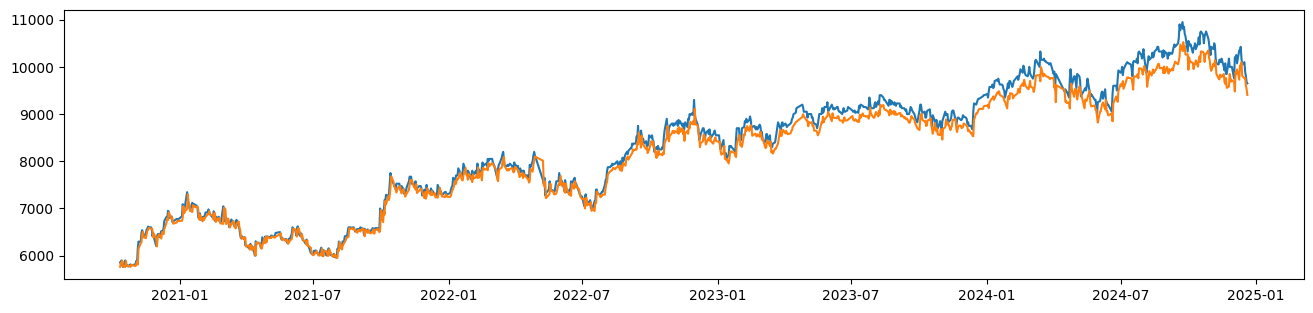

In [110]:
plt.figure(figsize=(16,3.5))
plt.plot(valid[['Close','prediction_GRU']],linewidth=1.5)

In [111]:
# Simpan hasil prediksi pada datatest dalam file xlsx
valid.to_excel('/content/drive/MyDrive/Project Tesis/PrediksiDataTest/BBCA_PREDIC_DATATEST_GRU.xlsx')

Prediksi 30 hari kedepan

In [112]:
def smooth_prediction(previous_value, predicted_value, alpha=0.9):
    """
    Applies exponential smoothing to the predicted value.
    :param previous_value: The previous actual value.
    :param predicted_value: The predicted value from the model.
    :param alpha: The smoothing factor (between 0 and 1).
    :return: The smoothed value.
    """
    return alpha * predicted_value + (1 - alpha) * previous_value


In [113]:
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# Misalkan 'data' adalah DataFrame yang berisi data harga yang akan diprediksi
# Contoh: data = pd.DataFrame({'Price': [....]})

# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values)

# Ambil panjang data
data_len = len(scaled_data)

# Ambil 30 data terakhir
data_input = scaled_data[data_len-30:data_len, :]

# Tanggal awal untuk prediksi
start_date = datetime.now()  # Anda bisa mengganti ini dengan tanggal tertentu

# Inisialisasi list untuk menyimpan hasil prediksi
hasil_prediksi_GRU_list = []

# Fungsi untuk smoothing prediksi
def smooth_prediction(previous_value, predicted_value, alpha=0.9):
    return alpha * previous_value + (1 - alpha) * predicted_value

# Melakukan prediksi untuk 30 hari ke depan
for day in range(30):
    # Reshape input untuk model GRU
    x_input = data_input.reshape(1, data_input.shape[0], 1)

    # Prediksi menggunakan model GRU
    predicted_value = model_RNN.predict(x_input)

    # Smooth hasil prediksi
    smoothed_value = smooth_prediction(data_input[-1, 0], predicted_value[0, 0], alpha=0.9)

    # Simpan hasil prediksi
    hasil_prediksi_GRU_list.append(smoothed_value)

    # Update data_input dengan prediksi yang baru
    data_input = np.append(data_input, smoothed_value).reshape(-1, 1)

    # Ambil 30 elemen terakhir
    data_input = data_input[-30:]

# Lakukan inverse scaling pada hasil prediksi
hasil_prediksi_GRU_list = scaler.inverse_transform(np.array(hasil_prediksi_GRU_list).reshape(-1, 1))

# Buat DataFrame dari list hasil_prediksi_GRU_list dan indeksnya berupa tanggal
df_hasil_prediksi_GRU = pd.DataFrame(
    hasil_prediksi_GRU_list,
    index=pd.date_range(start=start_date, periods=30, freq='D'),
    columns=['Prediction_GRU']
)

# Menamai kolom indeks sebagai "Date"
df_hasil_prediksi_GRU.index.name = 'Date'

# Simpan DataFrame ke dalam file xlsx
df_hasil_prediksi_GRU.to_excel('/content/drive/MyDrive/Project Tesis/Prediksi30hari/BBCA_PREDIC_30DAYS_GRU.xlsx')

# Cetak DataFrame hasil prediksi
print(df_hasil_prediksi_GRU)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

# Hyperparameter - LSTM



In [114]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define hyperparameters
# Sesuaikan input_size sesuai dengan jumlah fitur yang Anda miliki di dataset stok market
input_size = 5  # Misalnya: 'Open', 'High', 'Low', 'Close', 'Volume'
hidden_size = 64
output_size = 1
num_layers = 2
num_attention_heads = 4
learning_rate = 0.001
num_epochs = 100
num_time_steps = 10  # Jumlah langkah waktu untuk digunakan sebagai input fitur

[*********************100%***********************]  1 of 1 completed


Epoch [1/100], Training Loss (LSTM): 0.5964
Epoch [1/100], Validation Loss (LSTM): 1.1024
Epoch [1/100], Test Loss (LSTM): 2.8311
Epoch [2/100], Training Loss (LSTM): 0.5890
Epoch [2/100], Validation Loss (LSTM): 1.1099
Epoch [2/100], Test Loss (LSTM): 2.8391
Epoch [3/100], Training Loss (LSTM): 0.5817
Epoch [3/100], Validation Loss (LSTM): 1.1172
Epoch [3/100], Test Loss (LSTM): 2.8467
Epoch [4/100], Training Loss (LSTM): 0.5744
Epoch [4/100], Validation Loss (LSTM): 1.1245
Epoch [4/100], Test Loss (LSTM): 2.8542
Epoch [5/100], Training Loss (LSTM): 0.5672
Epoch [5/100], Validation Loss (LSTM): 1.1317
Epoch [5/100], Test Loss (LSTM): 2.8613
Epoch [6/100], Training Loss (LSTM): 0.5599
Epoch [6/100], Validation Loss (LSTM): 1.1388
Epoch [6/100], Test Loss (LSTM): 2.8682
Epoch [7/100], Training Loss (LSTM): 0.5527
Epoch [7/100], Validation Loss (LSTM): 1.1458
Epoch [7/100], Test Loss (LSTM): 2.8747
Epoch [8/100], Training Loss (LSTM): 0.5454
Epoch [8/100], Validation Loss (LSTM): 1.1527


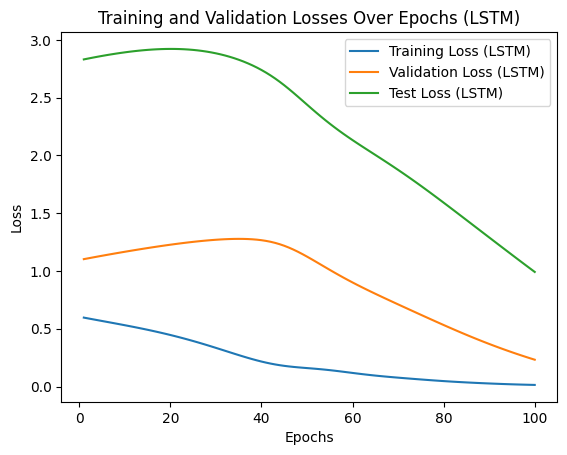

Validation Set Metrics (LSTM):
Mean Absolute Error (MAE): 0.4657
Mean Squared Error (MSE): 0.2320
Root Mean Squared Error (RMSE): 0.4817
Mean Absolute Percentage Error (MAPE): 49.2894

Test Set Metrics (LSTM):
Mean Absolute Error (MAE): 0.9711
Mean Squared Error (MSE): 0.9917
Root Mean Squared Error (RMSE): 0.9958
Mean Absolute Percentage Error (MAPE): 61.5749


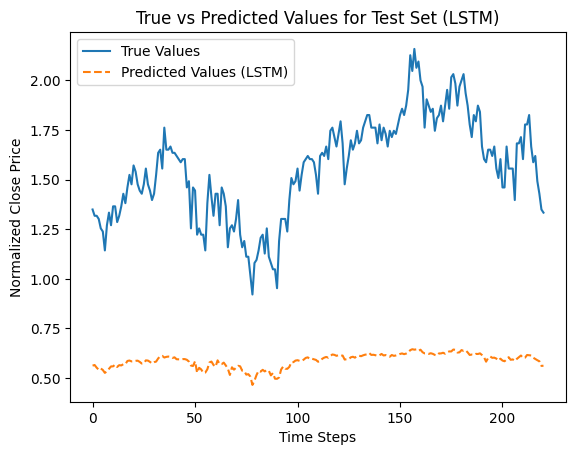

In [115]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define the stock symbol and date range
stock_symbol = "BBCA.JK"
start_date = "2019-01-01"
end_date = "2024-12-31"

# Fetch historical stock data from Yahoo Finance
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Reset index to make 'Date' a column again
stock_data.reset_index(inplace=True)

# Rename 'Adj Close' to 'Adjusted Close'
stock_data.rename(columns={'Adj Close': 'Adjusted Close'}, inplace=True)

# Use 'Date' as index
stock_data.set_index('Date', inplace=True)

# Normalize data
columns_to_normalize = ['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']
data_to_normalize = stock_data[columns_to_normalize].values

# Convert the data to PyTorch tensor
tensor_data = torch.tensor(data_to_normalize, dtype=torch.float32)

# Calculate mean and standard deviation for each column
mean = tensor_data.mean(dim=0)
std = tensor_data.std(dim=0)

# Normalize the data
normalized_data = (tensor_data - mean) / std

# Convert the normalized data back to a DataFrame
df_normalized = pd.DataFrame(normalized_data.numpy(), columns=columns_to_normalize)

# Add 'Date' column back to the DataFrame
df_normalized['Date'] = stock_data.index
data = df_normalized

# Define the percentage of data for training, validation, and testing
train_percent = 0.7
val_percent = 0.15
test_percent = 0.15

# Calculate the sizes of the train, validation, and test sets
train_size = int(train_percent * len(data))
val_size = int(val_percent * len(data))
test_size = len(data) - train_size - val_size

# Split the data into train, validation, and test sets
train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

# Define the features(inputs) and target columns
feature_columns = ['Low', 'Open', 'High']  # Note: Ensure that this list matches the expected input size
target_column = 'Close'

# Extract features and target for each dataset
train_features = train_data[feature_columns].values
train_target = train_data[target_column].values

val_features = val_data[feature_columns].values
val_target = val_data[target_column].values

test_features = test_data[feature_columns].values
test_target = test_data[target_column].values

# Convert data to PyTorch tensors
train_features = torch.tensor(train_features, dtype=torch.float32)
train_target = torch.tensor(train_target, dtype=torch.float32)
val_features = torch.tensor(val_features, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)
test_features = torch.tensor(test_features, dtype=torch.float32)
test_target = torch.tensor(test_target, dtype=torch.float32)

num_epochs= 100

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # The input x should have the shape (batch_size, sequence_length, input_size)
        x, (hn, cn) = self.lstm(x)  # Use both hidden state (hn) and cell state (cn)
        x = self.fc_output(x[:, -1, :])  # Take the output from the last time step
        return x

# Define hyperparameters for LSTM
hidden_size_lstm = 64
num_layers_lstm = 2

# Create the LSTM model instance
model_lstm = LSTMModel(3, hidden_size_lstm, 1, num_layers_lstm)  # Adjusted input_size to 3

# Define the loss function and optimizer for LSTM
criterion= nn.MSELoss()
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=0.001)  # Ensure learning rate is defined somewhere

# Lists to store training, validation, and test losses for LSTM
train_losses_lstm = []
val_losses_lstm = []
test_losses_lstm = []  # This list will store test loss for each epoch

# Training loop for LSTM
for epoch in range(num_epochs):
    model_lstm.train()
    optimizer_lstm.zero_grad()

    # Forward pass for LSTM
    outputs_lstm = model_lstm(train_features.unsqueeze(1))

    # Calculate the loss for LSTM
    loss_lstm = criterion(outputs_lstm, train_target.unsqueeze(1))

    # Backpropagation and optimization for LSTM
    loss_lstm.backward()
    optimizer_lstm.step()

    # Store the training loss for LSTM
    train_losses_lstm.append(loss_lstm.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss (LSTM): {loss_lstm.item():.4f}')

    # Validation loss for LSTM
    model_lstm.eval()
    with torch.no_grad():
        val_outputs_lstm = model_lstm(val_features.unsqueeze(1))
        val_loss_lstm = criterion(val_outputs_lstm, val_target.unsqueeze(1))

    # Store the validation loss for LSTM
    val_losses_lstm.append(val_loss_lstm.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss (LSTM): {val_loss_lstm.item():.4f}')

    # Test loss for LSTM
    with torch.no_grad():
        test_outputs_lstm = model_lstm(test_features.unsqueeze(1))
        test_loss_lstm = criterion(test_outputs_lstm, test_target.unsqueeze(1))

    # Store the test loss for each epoch for LSTM
    test_losses_lstm.append(test_loss_lstm.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss (LSTM): {test_loss_lstm.item():.4f}')

# Plotting the training and validation losses for LSTM
plt.plot(range(1, num_epochs + 1), train_losses_lstm, label='Training Loss (LSTM)')
plt.plot(range(1, num_epochs + 1), val_losses_lstm, label='Validation Loss (LSTM)')
plt.plot(range(1, num_epochs + 1), test_losses_lstm, label='Test Loss (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs (LSTM)')
plt.legend()
plt.show()

# Switch the LSTM model to evaluation mode
model_lstm.eval()

# Make predictions on the validation set using LSTM
with torch.no_grad():
    val_predictions_lstm = model_lstm(val_features.unsqueeze(1))

# Convert predictions and targets back to numpy arrays for LSTM
val_predictions_lstm = val_predictions_lstm.squeeze(1).numpy()

# Calculate evaluation metrics for validation set using LSTM
mae_val_lstm = mean_absolute_error(val_target.numpy(), val_predictions_lstm)
mse_val_lstm = mean_squared_error(val_target.numpy(), val_predictions_lstm)
rmse_val_lstm = np.sqrt(mse_val_lstm)
mape_val_lstm = calculate_mape(val_target.numpy(), val_predictions_lstm)

# Print the evaluation metrics for validation set using LSTM
print('Validation Set Metrics (LSTM):')
print(f'Mean Absolute Error (MAE): {mae_val_lstm:.4f}')
print(f'Mean Squared Error (MSE): {mse_val_lstm:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_val_lstm:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_val_lstm:.4f}')
print()

# Make predictions on the test set using LSTM
with torch.no_grad():
    test_predictions_lstm = model_lstm(test_features.unsqueeze(1))

# Convert predictions and targets back to numpy arrays for LSTM
test_predictions_lstm = test_predictions_lstm.squeeze(1).numpy()

# Calculate evaluation metrics for test set using LSTM
mae_test_lstm = mean_absolute_error(test_target.numpy(), test_predictions_lstm)
mse_test_lstm = mean_squared_error(test_target.numpy(), test_predictions_lstm)
rmse_test_lstm = np.sqrt(mse_test_lstm)
mape_test_lstm = calculate_mape(test_target.numpy(), test_predictions_lstm)

# Print the evaluation metrics for test set using LSTM
print('Test Set Metrics (LSTM):')
print(f'Mean Absolute Error (MAE): {mae_test_lstm:.4f}')
print(f'Mean Squared Error (MSE): {mse_test_lstm:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_test_lstm:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test_lstm:.4f}')

# Plotting the predicted values against true values for the test set using LSTM
plt.plot(test_target.numpy(), label='True Values')
plt.plot(test_predictions_lstm, label='Predicted Values (LSTM)', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Close Price')
plt.title('True vs Predicted Values for Test Set (LSTM)')
plt.legend()
plt.show()


# Hyperparameter - RNN

[*********************100%***********************]  1 of 1 completed


Epoch [1/100], Training Loss (RNN): 0.5632
Epoch [1/100], Validation Loss (RNN): 1.3448
Epoch [1/100], Test Loss (RNN): 3.2112
Epoch [2/100], Training Loss (RNN): 0.5071
Epoch [2/100], Validation Loss (RNN): 1.3268
Epoch [2/100], Test Loss (RNN): 3.1110
Epoch [3/100], Training Loss (RNN): 0.4561
Epoch [3/100], Validation Loss (RNN): 1.3065
Epoch [3/100], Test Loss (RNN): 3.0084
Epoch [4/100], Training Loss (RNN): 0.4099
Epoch [4/100], Validation Loss (RNN): 1.2848
Epoch [4/100], Test Loss (RNN): 2.9049
Epoch [5/100], Training Loss (RNN): 0.3682
Epoch [5/100], Validation Loss (RNN): 1.2613
Epoch [5/100], Test Loss (RNN): 2.8002
Epoch [6/100], Training Loss (RNN): 0.3308
Epoch [6/100], Validation Loss (RNN): 1.2359
Epoch [6/100], Test Loss (RNN): 2.6937
Epoch [7/100], Training Loss (RNN): 0.2975
Epoch [7/100], Validation Loss (RNN): 1.2079
Epoch [7/100], Test Loss (RNN): 2.5844
Epoch [8/100], Training Loss (RNN): 0.2681
Epoch [8/100], Validation Loss (RNN): 1.1768
Epoch [8/100], Test Los

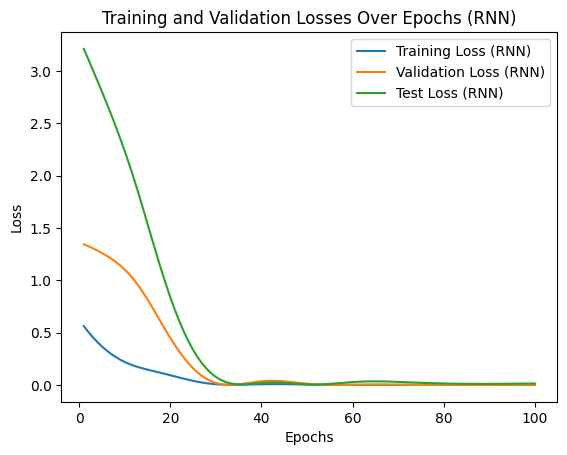

Validation Set Metrics (RNN):
Mean Absolute Error (MAE): 0.0316
Mean Squared Error (MSE): 0.0015
Root Mean Squared Error (RMSE): 0.0390
Mean Absolute Percentage Error (MAPE): 3.6291

Test Set Metrics (RNN):
Mean Absolute Error (MAE): 0.1035
Mean Squared Error (MSE): 0.0155
Root Mean Squared Error (RMSE): 0.1247
Mean Absolute Percentage Error (MAPE): 6.2545


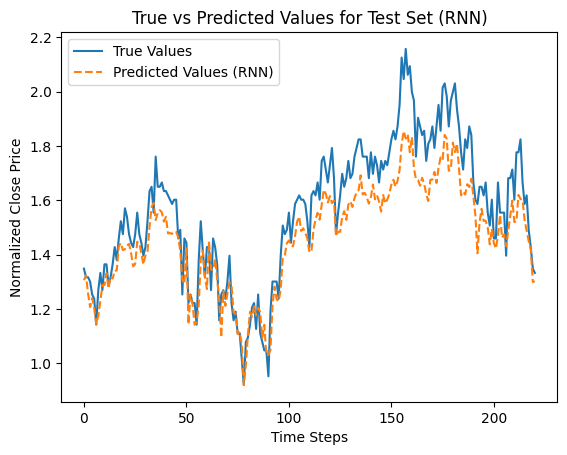

In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define the stock symbol and date range
stock_symbol = "BBCA.JK"
start_date = "2019-01-01"
end_date = "2024-12-31"

# Fetch historical stock data from Yahoo Finance
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Reset index to make 'Date' a column again
stock_data.reset_index(inplace=True)

# Rename 'Adj Close' to 'Adjusted Close'
stock_data.rename(columns={'Adj Close': 'Adjusted Close'}, inplace=True)

# Use 'Date' as index
stock_data.set_index('Date', inplace=True)

# Normalize data
columns_to_normalize = ['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']
data_to_normalize = stock_data[columns_to_normalize].values

# Convert the data to PyTorch tensor
tensor_data = torch.tensor(data_to_normalize, dtype=torch.float32)

# Calculate mean and standard deviation for each column
mean = tensor_data.mean(dim=0)
std = tensor_data.std(dim=0)

# Normalize the data
normalized_data = (tensor_data - mean) / std

# Convert the normalized data back to a DataFrame
df_normalized = pd.DataFrame(normalized_data.numpy(), columns=columns_to_normalize)

# Add 'Date' column back to the DataFrame
df_normalized['Date'] = stock_data.index
data = df_normalized

# Define the percentage of data for training, validation, and testing
train_percent = 0.7
val_percent = 0.15
test_percent = 0.15

# Calculate the sizes of the train, validation, and test sets
train_size = int(train_percent * len(data))
val_size = int(val_percent * len(data))
test_size = len(data) - train_size - val_size

# Split the data into train, validation, and test sets
train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

# Define the features(inputs) and target columns
feature_columns = ['Low', 'Open', 'High']  # Note: Ensure that this list matches the expected input size
target_column = 'Close'

# Extract features and target for each dataset
train_features = train_data[feature_columns].values
train_target = train_data[target_column].values

val_features = val_data[feature_columns].values
val_target = val_data[target_column].values

test_features = test_data[feature_columns].values
test_target = test_data[target_column].values

# Convert data to PyTorch tensors
train_features = torch.tensor(train_features, dtype=torch.float32)
train_target = torch.tensor(train_target, dtype=torch.float32)
val_features = torch.tensor(val_features, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)
test_features = torch.tensor(test_features, dtype=torch.float32)
test_target = torch.tensor(test_target, dtype=torch.float32)

num_epochs= 100

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # The input x should have the shape (batch_size, sequence_length, input_size)
        x, hn = self.rnn(x)  # hn is the hidden state
        x = self.fc_output(x[:, -1, :])  # Take the output from the last time step
        return x

# Define hyperparameters for RNN
hidden_size_rnn = 64
num_layers_rnn = 2

# Create the RNN model instance
model_rnn = RNNModel(3, hidden_size_rnn, 1, num_layers_rnn)  # Adjusted input_size to 3

# Define the loss function and optimizer for RNN
criterion= nn.MSELoss()
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=0.001)  # Ensure learning rate is defined somewhere

# Lists to store training, validation, and test losses for RNN
train_losses_rnn = []
val_losses_rnn = []
test_losses_rnn = []  # This list will store test loss for each epoch

# Training loop for RNN
for epoch in range(num_epochs):
    model_rnn.train()
    optimizer_rnn.zero_grad()

    # Forward pass for RNN
    outputs_rnn = model_rnn(train_features.unsqueeze(1))

    # Calculate the loss for RNN
    loss_rnn = criterion(outputs_rnn, train_target.unsqueeze(1))

    # Backpropagation and optimization for RNN
    loss_rnn.backward()
    optimizer_rnn.step()

    # Store the training loss for RNN
    train_losses_rnn.append(loss_rnn.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss (RNN): {loss_rnn.item():.4f}')

    # Validation loss for RNN
    model_rnn.eval()
    with torch.no_grad():
        val_outputs_rnn = model_rnn(val_features.unsqueeze(1))
        val_loss_rnn = criterion(val_outputs_rnn, val_target.unsqueeze(1))

    # Store the validation loss for RNN
    val_losses_rnn.append(val_loss_rnn.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss (RNN): {val_loss_rnn.item():.4f}')

    # Test loss for RNN
    with torch.no_grad():
        test_outputs_rnn = model_rnn(test_features.unsqueeze(1))
        test_loss_rnn = criterion(test_outputs_rnn, test_target.unsqueeze(1))

    # Store the test loss for each epoch for RNN
    test_losses_rnn.append(test_loss_rnn.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss (RNN): {test_loss_rnn.item():.4f}')

# Plotting the training and validation losses for RNN
plt.plot(range(1, num_epochs + 1), train_losses_rnn, label='Training Loss (RNN)')
plt.plot(range(1, num_epochs + 1), val_losses_rnn, label='Validation Loss (RNN)')
plt.plot(range(1, num_epochs + 1), test_losses_rnn, label='Test Loss (RNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs (RNN)')
plt.legend()
plt.show()

# Switch the RNN model to evaluation mode
model_rnn.eval()

# Make predictions on the validation set using RNN
with torch.no_grad():
    val_predictions_rnn = model_rnn(val_features.unsqueeze(1))

# Convert predictions and targets back to numpy arrays for RNN
val_predictions_rnn = val_predictions_rnn.squeeze(1).numpy()

# Calculate evaluation metrics for validation set using RNN
mae_val_rnn = mean_absolute_error(val_target.numpy(), val_predictions_rnn)
mse_val_rnn = mean_squared_error(val_target.numpy(), val_predictions_rnn)
rmse_val_rnn = np.sqrt(mse_val_rnn)
mape_val_rnn = calculate_mape(val_target.numpy(), val_predictions_rnn)

# Print the evaluation metrics for validation set using RNN
print('Validation Set Metrics (RNN):')
print(f'Mean Absolute Error (MAE): {mae_val_rnn:.4f}')
print(f'Mean Squared Error (MSE): {mse_val_rnn:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_val_rnn:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_val_rnn:.4f}')
print()

# Make predictions on the test set using RNN
with torch.no_grad():
    test_predictions_rnn = model_rnn(test_features.unsqueeze(1))

# Convert predictions and targets back to numpy arrays for RNN
test_predictions_rnn = test_predictions_rnn.squeeze(1).numpy()

# Calculate evaluation metrics for test set using RNN
mae_test_rnn = mean_absolute_error(test_target.numpy(), test_predictions_rnn)
mse_test_rnn = mean_squared_error(test_target.numpy(), test_predictions_rnn)
rmse_test_rnn = np.sqrt(mse_test_rnn)
mape_test_rnn = calculate_mape(test_target.numpy(), test_predictions_rnn)

# Print the evaluation metrics for test set using RNN
print('Test Set Metrics (RNN):')
print(f'Mean Absolute Error (MAE): {mae_test_rnn:.4f}')
print(f'Mean Squared Error (MSE): {mse_test_rnn:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_test_rnn:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test_rnn:.4f}')

# Plotting the predicted values against true values for the test set using RNN
plt.plot(test_target.numpy(), label='True Values')
plt.plot(test_predictions_rnn, label='Predicted Values (RNN)', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Close Price')
plt.title('True vs Predicted Values for Test Set (RNN)')
plt.legend()
plt.show()


# Hyperparameter - GRU

[*********************100%***********************]  1 of 1 completed


Epoch [1/100], Training Loss (GRU): 0.7878
Epoch [1/100], Validation Loss (GRU): 0.7450
Epoch [1/100], Test Loss (GRU): 2.2171
Epoch [2/100], Training Loss (GRU): 0.7639
Epoch [2/100], Validation Loss (GRU): 0.7501
Epoch [2/100], Test Loss (GRU): 2.2120
Epoch [3/100], Training Loss (GRU): 0.7405
Epoch [3/100], Validation Loss (GRU): 0.7552
Epoch [3/100], Test Loss (GRU): 2.2067
Epoch [4/100], Training Loss (GRU): 0.7173
Epoch [4/100], Validation Loss (GRU): 0.7602
Epoch [4/100], Test Loss (GRU): 2.2011
Epoch [5/100], Training Loss (GRU): 0.6944
Epoch [5/100], Validation Loss (GRU): 0.7651
Epoch [5/100], Test Loss (GRU): 2.1949
Epoch [6/100], Training Loss (GRU): 0.6716
Epoch [6/100], Validation Loss (GRU): 0.7698
Epoch [6/100], Test Loss (GRU): 2.1879
Epoch [7/100], Training Loss (GRU): 0.6488
Epoch [7/100], Validation Loss (GRU): 0.7743
Epoch [7/100], Test Loss (GRU): 2.1800
Epoch [8/100], Training Loss (GRU): 0.6259
Epoch [8/100], Validation Loss (GRU): 0.7784
Epoch [8/100], Test Los

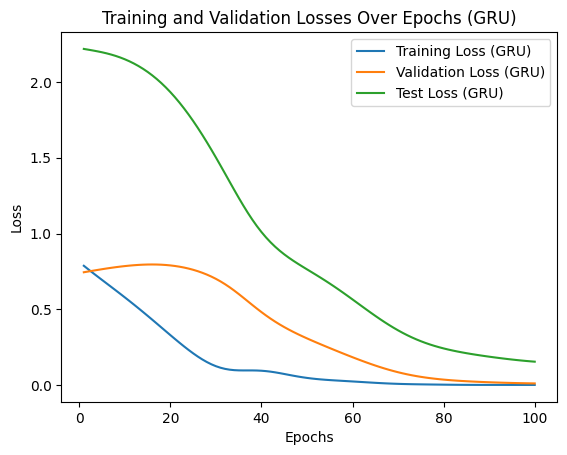

Validation Set Metrics (GRU):
Mean Absolute Error (MAE): 0.0950
Mean Squared Error (MSE): 0.0124
Root Mean Squared Error (RMSE): 0.1111
Mean Absolute Percentage Error (MAPE): 9.5814

Test Set Metrics (GRU):
Mean Absolute Error (MAE): 0.3667
Mean Squared Error (MSE): 0.1556
Root Mean Squared Error (RMSE): 0.3945
Mean Absolute Percentage Error (MAPE): 22.5914


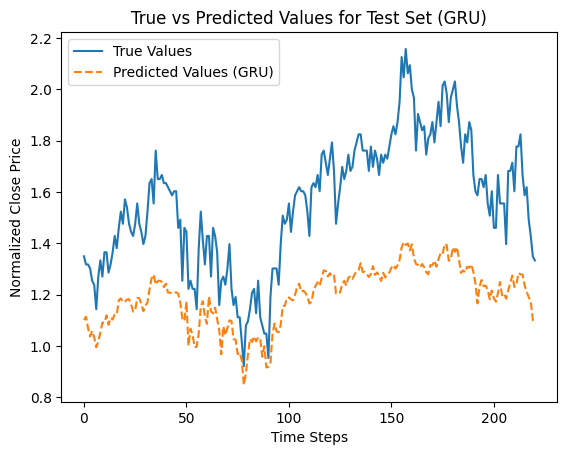

In [117]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define the stock symbol and date range
stock_symbol = "BBCA.JK"
start_date = "2019-01-01"
end_date = "2024-12-31"

# Fetch historical stock data from Yahoo Finance
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Reset index to make 'Date' a column again
stock_data.reset_index(inplace=True)

# Rename 'Adj Close' to 'Adjusted Close'
stock_data.rename(columns={'Adj Close': 'Adjusted Close'}, inplace=True)

# Use 'Date' as index
stock_data.set_index('Date', inplace=True)

# Normalize data
columns_to_normalize = ['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']
data_to_normalize = stock_data[columns_to_normalize].values

# Convert the data to PyTorch tensor
tensor_data = torch.tensor(data_to_normalize, dtype=torch.float32)

# Calculate mean and standard deviation for each column
mean = tensor_data.mean(dim=0)
std = tensor_data.std(dim=0)

# Normalize the data
normalized_data = (tensor_data - mean) / std

# Convert the normalized data back to a DataFrame
df_normalized = pd.DataFrame(normalized_data.numpy(), columns=columns_to_normalize)

# Add 'Date' column back to the DataFrame
df_normalized['Date'] = stock_data.index
data = df_normalized

# Define the percentage of data for training, validation, and testing
train_percent = 0.7
val_percent = 0.15
test_percent = 0.15

# Calculate the sizes of the train, validation, and test sets
train_size = int(train_percent * len(data))
val_size = int(val_percent * len(data))
test_size = len(data) - train_size - val_size

# Split the data into train, validation, and test sets
train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

# Define the features(inputs) and target columns
feature_columns = ['Low', 'Open', 'High']  # Note: Ensure that this list matches the expected input size
target_column = 'Close'

# Extract features and target for each dataset
train_features = train_data[feature_columns].values
train_target = train_data[target_column].values

val_features = val_data[feature_columns].values
val_target = val_data[target_column].values

test_features = test_data[feature_columns].values
test_target = test_data[target_column].values

# Convert data to PyTorch tensors
train_features = torch.tensor(train_features, dtype=torch.float32)
train_target = torch.tensor(train_target, dtype=torch.float32)
val_features = torch.tensor(val_features, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)
test_features = torch.tensor(test_features, dtype=torch.float32)
test_target = torch.tensor(test_target, dtype=torch.float32)

num_epochs = 100

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # The input x should have the shape (batch_size, sequence_length, input_size)
        x, hn = self.gru(x)  # hn is the hidden state
        x = self.fc_output(x[:, -1, :])  # Take the output from the last time step
        return x

# Define hyperparameters for GRU
hidden_size_gru = 64
num_layers_gru = 2

# Create the GRU model instance
model_gru = RNNModel(3, hidden_size_gru, 1, num_layers_gru)  # Adjusted input_size to 3

# Define the loss function and optimizer for GRU
criterion = nn.MSELoss()
optimizer_gru = optim.Adam(model_gru.parameters(), lr=0.001)  # Ensure learning rate is defined somewhere

# Lists to store training, validation, and test losses for GRU
train_losses_gru = []
val_losses_gru = []
test_losses_gru = []  # This list will store test loss for each epoch

# Training loop for GRU
for epoch in range(num_epochs):
    model_gru.train()
    optimizer_gru.zero_grad()

    # Forward pass for GRU
    outputs_gru = model_gru(train_features.unsqueeze(1))

    # Calculate the loss for GRU
    loss_gru = criterion(outputs_gru, train_target.unsqueeze(1))

    # Backpropagation and optimization for GRU
    loss_gru.backward()
    optimizer_gru.step()

    # Store the training loss for GRU
    train_losses_gru.append(loss_gru.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss (GRU): {loss_gru.item():.4f}')

    # Validation loss for GRU
    model_gru.eval()
    with torch.no_grad():
        val_outputs_gru = model_gru(val_features.unsqueeze(1))
        val_loss_gru = criterion(val_outputs_gru, val_target.unsqueeze(1))

    # Store the validation loss for GRU
    val_losses_gru.append(val_loss_gru.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss (GRU): {val_loss_gru.item():.4f}')

    # Test loss for GRU
    with torch.no_grad():
        test_outputs_gru = model_gru(test_features.unsqueeze(1))
        test_loss_gru = criterion(test_outputs_gru, test_target.unsqueeze(1))

    # Store the test loss for each epoch for GRU
    test_losses_gru.append(test_loss_gru.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss (GRU): {test_loss_gru.item():.4f}')

# Plotting the training and validation losses for GRU
plt.plot(range(1, num_epochs + 1), train_losses_gru, label='Training Loss (GRU)')
plt.plot(range(1, num_epochs + 1), val_losses_gru, label='Validation Loss (GRU)')
plt.plot(range(1, num_epochs + 1), test_losses_gru, label='Test Loss (GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs (GRU)')
plt.legend()
plt.show()

# Switch the GRU model to evaluation mode
model_gru.eval()

# Make predictions on the validation set using GRU
with torch.no_grad():
    val_predictions_gru = model_gru(val_features.unsqueeze(1))

# Convert predictions and targets back to numpy arrays for GRU
val_predictions_gru = val_predictions_gru.squeeze(1).numpy()

# Calculate evaluation metrics for validation set using GRU
mae_val_gru = mean_absolute_error(val_target.numpy(), val_predictions_gru)
mse_val_gru = mean_squared_error(val_target.numpy(), val_predictions_gru)
rmse_val_gru = np.sqrt(mse_val_gru)
mape_val_gru = calculate_mape(val_target.numpy(), val_predictions_gru)

# Print the evaluation metrics for validation set using GRU
print('Validation Set Metrics (GRU):')
print(f'Mean Absolute Error (MAE): {mae_val_gru:.4f}')
print(f'Mean Squared Error (MSE): {mse_val_gru:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_val_gru:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_val_gru:.4f}')
print()

# Make predictions on the test set using GRU
with torch.no_grad():
    test_predictions_gru = model_gru(test_features.unsqueeze(1))

# Convert predictions and targets back to numpy arrays for GRU
test_predictions_gru = test_predictions_gru.squeeze(1).numpy()

# Calculate evaluation metrics for test set using GRU
mae_test_gru = mean_absolute_error(test_target.numpy(), test_predictions_gru)
mse_test_gru = mean_squared_error(test_target.numpy(), test_predictions_gru)
rmse_test_gru = np.sqrt(mse_test_gru)
mape_test_gru = calculate_mape(test_target.numpy(), test_predictions_gru)

# Print the evaluation metrics for test set using GRU
print('Test Set Metrics (GRU):')
print(f'Mean Absolute Error (MAE): {mae_test_gru:.4f}')
print(f'Mean Squared Error (MSE): {mse_test_gru:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_test_gru:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test_gru:.4f}')

# Plotting the predicted values against true values for the test set using GRU
plt.plot(test_target.numpy(), label='True Values')
plt.plot(test_predictions_gru, label='Predicted Values (GRU)', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Close Price')
plt.title('True vs Predicted Values for Test Set (GRU)')
plt.legend()
plt.show()


# Transformers

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/100], Training Loss: 0.9153
Epoch [1/100], Validation Loss: 0.0596
Epoch [1/100], Test Loss: 0.0256
Epoch [2/100], Training Loss: 3.2641
Epoch [2/100], Validation Loss: 0.7878
Epoch [2/100], Test Loss: 0.2288
Epoch [3/100], Training Loss: 0.9087
Epoch [3/100], Validation Loss: 0.1683
Epoch [3/100], Test Loss: 0.0932
Epoch [4/100], Training Loss: 0.1736
Epoch [4/100], Validation Loss: 0.1944
Epoch [4/100], Test Loss: 1.1364
Epoch [5/100], Training Loss: 0.4828
Epoch [5/100], Validation Loss: 0.9818
Epoch [5/100], Test Loss: 2.6499
Epoch [6/100], Training Loss: 0.4103
Epoch [6/100], Validation Loss: 1.3143
Epoch [6/100], Test Loss: 3.1179
Epoch [7/100], Training Loss: 0.2784
Epoch [7/100], Validation Loss: 1.0273
Epoch [7/100], Test Loss: 2.5934
Epoch [8/100], Training Loss: 0.2018
Epoch [8/100], Validation Loss: 0.5117
Epoch [8/100], Test Loss: 1.6784
Epoch [9/100], Training Loss: 0.1386
Epoch [9/100], Validation Loss: 0.1403
Epoch [9/100], Test Loss: 0.8908
Epoch [10/100], Tra

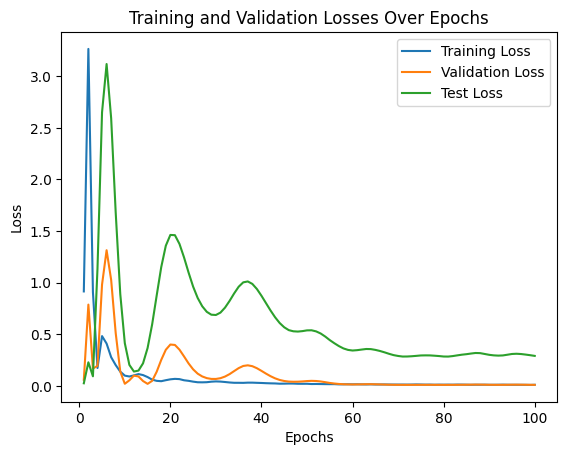

Final Test Loss: 0.2910

Validation Set Metrics:
Mean Absolute Error (MAE): 0.0779
Mean Squared Error (MSE): 0.0103
Root Mean Squared Error (RMSE): 0.1016
Mean Absolute Percentage Error (MAPE): 8.3129

Test Set Metrics:
Mean Absolute Error (MAE): 0.4955
Mean Squared Error (MSE): 0.2910
Root Mean Squared Error (RMSE): 0.5394
Mean Absolute Percentage Error (MAPE): 30.2869


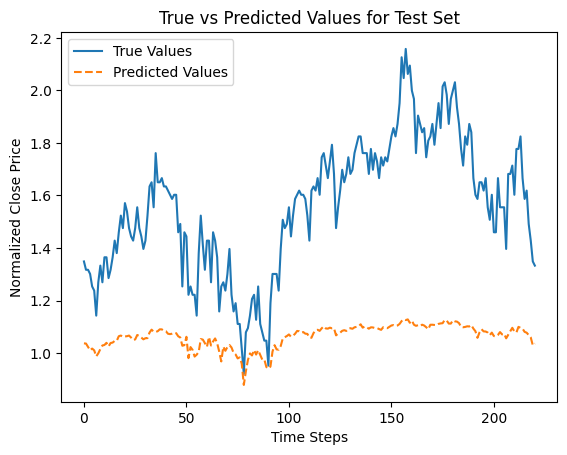

In [118]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define the stock symbol and date range
stock_symbol = "BBCA.JK"
start_date = "2019-01-01"
end_date = "2024-12-31"

# Fetch historical stock data from Yahoo Finance
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Reset index to make 'Date' a column again
stock_data.reset_index(inplace=True)

# Rename 'Adj Close' to 'Adjusted Close'
stock_data.rename(columns={'Adj Close': 'Adjusted Close'}, inplace=True)

# Use 'Date' as index
stock_data.set_index('Date', inplace=True)

# Normalize data
columns_to_normalize = ['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']
data_to_normalize = stock_data[columns_to_normalize].values

# Convert the data to PyTorch tensor
tensor_data = torch.tensor(data_to_normalize, dtype=torch.float32)

# Calculate mean and standard deviation for each column
mean = tensor_data.mean(dim=0)
std = tensor_data.std(dim=0)

# Normalize the data
normalized_data = (tensor_data - mean) / std

# Convert the normalized data back to a DataFrame
df_normalized = pd.DataFrame(normalized_data.numpy(), columns=columns_to_normalize)

# Add 'Date' column back to the DataFrame
df_normalized['Date'] = stock_data.index
data = df_normalized

# Define the percentage of data for training, validation, and testing
train_percent = 0.7
val_percent = 0.15
test_percent = 0.15

# Calculate the sizes of the train, validation, and test sets
train_size = int(train_percent * len(data))
val_size = int(val_percent * len(data))
test_size = len(data) - train_size - val_size

# Split the data into train, validation, and test sets
train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

# Define the features and target columns
feature_columns = ['Low', 'Open', 'High']
target_column = 'Close'

# Extract features and target for each dataset
train_features = train_data[feature_columns].values
train_target = train_data[target_column].values

val_features = val_data[feature_columns].values
val_target = val_data[target_column].values

test_features = test_data[feature_columns].values
test_target = test_data[target_column].values

# Convert data to PyTorch tensors
train_features = torch.tensor(train_features, dtype=torch.float32)
train_target = torch.tensor(train_target, dtype=torch.float32)
val_features = torch.tensor(val_features, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)
test_features = torch.tensor(test_features, dtype=torch.float32)
test_target = torch.tensor(test_target, dtype=torch.float32)

# Define a simple Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_attention_heads):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=num_attention_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers
        )
        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # Adjust input shape for the transformer
        x = self.transformer(x, x)  # Set source and target as the same data
        x = x.permute(1, 0, 2)  # Restore the original shape
        x = self.fc_output(x[:, -1, :])  # Use the last layer's output for prediction
        return x

# Define hyperparameters
input_size = len(feature_columns)
hidden_size = 64
output_size = 1
num_layers = 2
num_attention_heads = 4
learning_rate = 0.001
num_epochs = 100

# Create the model instance
model = TransformerModel(input_size, hidden_size, output_size, num_layers, num_attention_heads)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store training, validation, and test losses
train_losses = []
val_losses = []
test_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(train_features.unsqueeze(1))

    # Calculate the loss
    loss = criterion(outputs, train_target.unsqueeze(1))

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    # Store the training loss
    train_losses.append(loss.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}')

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_features.unsqueeze(1))
        val_loss = criterion(val_outputs, val_target.unsqueeze(1))

    # Store the validation loss
    val_losses.append(val_loss.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss.item():.4f}')

    # Test loss
    with torch.no_grad():
        test_outputs = model(test_features.unsqueeze(1))
        test_loss = criterion(test_outputs, test_target.unsqueeze(1))

    # Store the test loss for each epoch
    test_losses.append(test_loss.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {test_loss.item():.4f}')

# Plotting the training and validation losses
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.show()


# Print the test loss for the last epoch
print(f'Final Test Loss: {test_losses[-1]:.4f}')
print()

# Switch the model to evaluation mode
model.eval()

# Make predictions on the validation set
with torch.no_grad():
    val_predictions = model(val_features.unsqueeze(1))

# Convert predictions and targets back to numpy arrays
val_predictions = val_predictions.squeeze(1).numpy()
val_target_numpy = val_target.numpy()

# Calculate evaluation metrics for validation set
mae_val = mean_absolute_error(val_target_numpy, val_predictions)
mse_val = mean_squared_error(val_target_numpy, val_predictions)
rmse_val = np.sqrt(mse_val)
mape_val = calculate_mape(val_target_numpy, val_predictions)

# Print the evaluation metrics for validation set
print('Validation Set Metrics:')
print(f'Mean Absolute Error (MAE): {mae_val:.4f}')
print(f'Mean Squared Error (MSE): {mse_val:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_val:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_val:.4f}')
print()

# Make predictions on the test set
with torch.no_grad():
    test_predictions = model(test_features.unsqueeze(1))

# Convert predictions and targets back to numpy arrays
test_predictions = test_predictions.squeeze(1).numpy()
test_target_numpy = test_target.numpy()

# Calculate evaluation metrics for test set
mae_test = mean_absolute_error(test_target_numpy, test_predictions)
mse_test = mean_squared_error(test_target_numpy, test_predictions)
rmse_test = np.sqrt(mse_test)
mape_test = calculate_mape(test_target_numpy, test_predictions)

# Print the evaluation metrics for test set
print('Test Set Metrics:')
print(f'Mean Absolute Error (MAE): {mae_test:.4f}')
print(f'Mean Squared Error (MSE): {mse_test:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_test:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.4f}')

# Plotting the predicted values against true values for the test set
plt.plot(test_target_numpy, label='True Values')
plt.plot(test_predictions, label='Predicted Values', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Close Price')
plt.title('True vs Predicted Values for Test Set')
plt.legend()
plt.show()
